# Data Challenge - Advanced Machine Learning


**The data challenge is proposed by Idemia**

## Description of the data challenge

You have at your disposal 100000 images of human faces, and their occlusion label.
The goal of this challenge is to regress the percentage of the face that is occluded.
We also want to have similar performances on female and male, the gender label is given for the train database.

Below is the formula of the evaluation score. You'll first need to compute the error made by your model for men and women separetely. The error is measured as follows

$$
 Err = \frac{\sum_{i}{w_i(p_i - GT_i)^2}}{\sum_{i}{w_i}}, w_i = \frac{1}{30} + GT_i,
$$
where $GT_i$ is the ground truth and p_i the prediction made by your model. 

Then, the final score for the leaderboard is given by

$$
Score = \frac{Err_F + Err_M}{2} + \left | Err_F - Err_M \right |,
$$
where $Err_F$ and $Err_M$ are the errors obtained for female and men, respectively.

Hereafter we show you how to load the data and run a naive baseline using a pretrained model.

### Downloading the Data:

You can download the Dataset from the below links: https://partage.imt.fr/index.php/s/mscQABX4oZxx7ax

In [2]:
# Import required libraries to run the naive baseline
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small

c:\Users\ASUS\envs\virtual\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load dataframes

In [3]:
df_train = pd.read_csv("listes_training/data_100K/train_100K.csv", delimiter=' ')
df_test = pd.read_csv("listes_training/data_100K/test_students.csv", delimiter=' ')

image_dir = "crops_100K"

df_train = df_train.dropna()
df_test = df_test.dropna()

In [4]:
def error_fn(df):
    pred = df.loc[:, "pred"]
    ground_truth = df.loc[:, "target"]
    weight = 1/30 + ground_truth

    return np.sum(((pred - ground_truth)**2) * weight, axis=0) / np.sum(weight, axis=0)

def metric_fn(female, male):
    err_male = error_fn(male)
    err_female = error_fn(female)
    print("Male error: ", err_male)
    print("Female error: ", err_female)
    
    return (err_male + err_female) / 2 + abs(err_male - err_female)

In [5]:
df_train.tail()

,filename,FaceOcclusion,gender
101340,database3/database3/m.01drbr/85-FaceId-0_align...,0.017,1.000
101341,database3/database3/m.01drbr/86-FaceId-0_align...,0.152,1.000
101342,database3/database3/m.01drbr/87-FaceId-0_align...,0.004,0.999
101343,database3/database3/m.01drbr/90-FaceId-0_align...,0.012,1.000
101344,database3/database3/m.01drbr/92-FaceId-0_align...,0.036,1.000


In [6]:
df_test.head()

,filename
0,database2/database2/test/0.jpg
1,database2/database2/test/1.jpg
2,database2/database2/test/2.jpg
3,database2/database2/test/3.jpg
4,database2/database2/test/4.jpg


<Axes: >

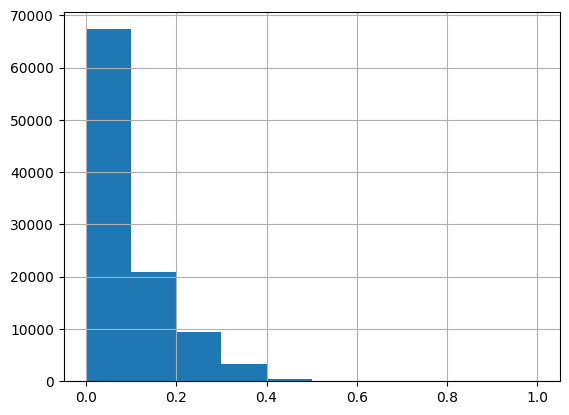

In [7]:
df_train['FaceOcclusion'].hist()

Text(0.5, 1.0, 'number of men and women in each bin of 0.01 of FaceOcclusion')

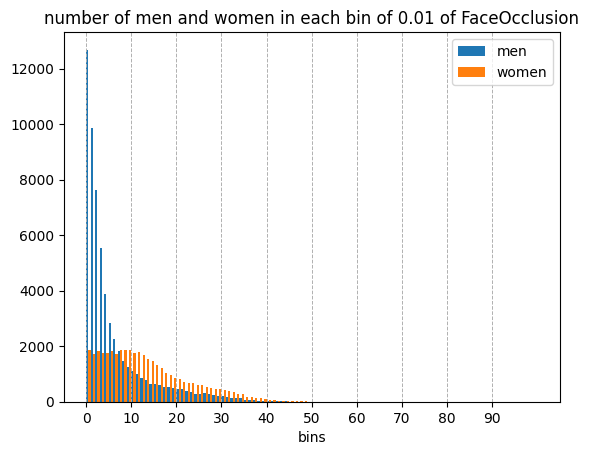

In [8]:
# Extracting histogram values for men and women
n_bins = 100
men = df_train[df_train['gender'] > 0.5]
women = df_train[df_train['gender'] < 0.5]
counts_men, bin_edges_men = np.histogram(men['FaceOcclusion'], bins=n_bins)
counts_women, bin_edges_women = np.histogram(women['FaceOcclusion'], bins=n_bins)

# Plotting the histograms
plt.bar(np.arange(n_bins)+0.25,counts_men, label = "men",width=0.5)
plt.bar(np.arange(n_bins)+0.75,counts_women, label = "women", width=0.5)
plt.legend()
plt.xlabel('bins')
plt.xticks(np.arange(0,100,10))#,np.arange(n_bins/10+1))
plt.grid(axis='x', linestyle='--', linewidth=0.7)
plt.title('number of men and women in each bin of '+ str(1/n_bins)+' of FaceOcclusion')

### Split Dataframe in train and val

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Randomly disrupt the dataset
df_train_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

df_train, df_val = train_test_split(df_train_shuffled, test_size=0.2, random_state=42)

# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

print("Training set:")
print(df_train.head())
print("\nValidation set:")
print(df_val.head())

Training set:
                                            filename  FaceOcclusion  gender
0                          database1/img00015966.jpg          0.015   0.997
1  database3/database3/m.01bczm/134-FaceId-0_alig...          0.011   0.998
2  database3/database3/m.01bldq/0-FaceId-0_align.jpg          0.071   0.997
3                          database1/img00017957.jpg          0.351   0.001
4                          database1/img00020727.jpg          0.128   0.001

Validation set:
                                            filename  FaceOcclusion  gender
0  database3/database3/m.01b1jr/84-FaceId-0_align...          0.061   1.000
1  database3/database3/m.018j3w/68-FaceId-0_align...          0.213   0.845
2  database3/database3/m.01bjs2/47-FaceId-0_align...          0.195   0.999
3                          database1/img00010973.jpg          0.015   0.999
4  database3/database3/m.01541z/61-FaceId-0_align...          0.108   0.001


In [10]:
len(df_train), len(df_val), len(df_test)

(81072, 20269, 30507)

### Make Dataset and Dataloader

In [11]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")
        y = row['FaceOcclusion']
        gender = row['gender']

        X = self.transform(img)
        y = np.float32(y)

        return X, y, gender, filename

In [12]:
training_set = Dataset(df_train, image_dir)
validation_set = Dataset(df_val, image_dir)

params_train = {'batch_size': 8,
          'shuffle': True,
          'num_workers': 0}

params_val = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

training_generator = torch.utils.data.DataLoader(training_set, **params_train)
validation_generator = torch.utils.data.DataLoader(validation_set, **params_val)

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

### First step - choose proper pre-trained model

#### Mobilenet

In [14]:
model = torchvision.models.mobilenet_v3_small(num_classes=1)
if torch.cuda.is_available():
    model.cuda()    

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 3

for n in range(num_epochs):
    print(f"Epoch {n}")
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        # Transfer to GPU
        X, y = X.to(device), y.to(device)
        y = torch.reshape(y, (len(y), 1))
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        if loss.isnan():
            print(filename)
            print('label', y)
            print('y_pred', y_pred)
            break

        if batch_idx % 200 == 0:
            print(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch 0


  0%|          | 0/10134 [00:00<?, ?it/s]

tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)


  2%|▏         | 202/10134 [00:16<11:37, 14.25it/s]

tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 402/10134 [00:30<09:31, 17.02it/s]

tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▌         | 602/10134 [00:44<10:51, 14.64it/s]

tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 804/10134 [00:56<08:54, 17.45it/s]

tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 1002/10134 [01:09<11:46, 12.92it/s]

tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 1204/10134 [01:22<08:15, 18.02it/s]

tensor(0.0069, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▍        | 1404/10134 [01:35<08:37, 16.88it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▌        | 1602/10134 [01:47<08:28, 16.77it/s]

tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 1802/10134 [02:00<09:03, 15.34it/s]

tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 2004/10134 [02:13<08:40, 15.61it/s]

tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 2202/10134 [02:27<10:01, 13.20it/s]

tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▎       | 2404/10134 [02:43<08:08, 15.82it/s]

tensor(0.0028, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 2604/10134 [02:56<07:52, 15.93it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 2802/10134 [03:09<07:33, 16.17it/s]

tensor(0.0031, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|██▉       | 3002/10134 [03:22<07:19, 16.21it/s]

tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 3204/10134 [03:35<07:30, 15.39it/s]

tensor(0.0056, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▎      | 3402/10134 [03:48<07:11, 15.60it/s]

tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▌      | 3604/10134 [04:01<06:58, 15.59it/s]

tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 3804/10134 [04:14<06:47, 15.54it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|███▉      | 4004/10134 [04:26<06:12, 16.46it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████▏     | 4202/10134 [04:39<06:03, 16.31it/s]

tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)


 43%|████▎     | 4404/10134 [04:51<05:57, 16.05it/s]

tensor(0.0054, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▌     | 4602/10134 [05:04<05:46, 15.95it/s]

tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 4802/10134 [05:17<05:43, 15.53it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 5004/10134 [05:30<05:19, 16.06it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████▏    | 5204/10134 [05:42<05:03, 16.26it/s]

tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward0>)


 53%|█████▎    | 5404/10134 [05:55<05:06, 15.44it/s]

tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▌    | 5604/10134 [06:07<04:46, 15.81it/s]

tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward0>)


 57%|█████▋    | 5802/10134 [06:20<04:45, 15.19it/s]

tensor(0.0021, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 6004/10134 [06:33<04:18, 16.00it/s]

tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 6202/10134 [06:46<04:46, 13.71it/s]

tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 6404/10134 [06:59<03:40, 16.88it/s]

tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▌   | 6602/10134 [07:11<03:29, 16.85it/s]

tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 6802/10134 [07:22<03:08, 17.69it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 7002/10134 [07:34<03:02, 17.20it/s]

tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)


 71%|███████   | 7204/10134 [07:45<02:46, 17.57it/s]

tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 7402/10134 [07:56<02:35, 17.62it/s]

tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▌  | 7604/10134 [08:08<02:25, 17.38it/s]

tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 7802/10134 [08:19<02:19, 16.69it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 8004/10134 [08:31<01:59, 17.76it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████  | 8204/10134 [08:42<01:48, 17.77it/s]

tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 8404/10134 [08:53<01:36, 17.88it/s]

tensor(0.0055, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▍ | 8604/10134 [09:05<01:26, 17.72it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 8804/10134 [09:16<01:13, 18.17it/s]

tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▉ | 9004/10134 [09:27<01:02, 18.08it/s]

tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)


 91%|█████████ | 9204/10134 [09:38<00:50, 18.47it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 9404/10134 [09:50<00:39, 18.37it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▍| 9602/10134 [10:01<00:31, 17.01it/s]

tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 9804/10134 [10:13<00:19, 16.92it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▊| 10002/10134 [10:25<00:07, 17.04it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 10134/10134 [10:32<00:00, 16.01it/s]


Epoch 1


  0%|          | 3/10134 [00:00<07:01, 24.05it/s]

tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)


  2%|▏         | 207/10134 [00:05<04:42, 35.11it/s]

tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 407/10134 [00:11<04:37, 35.02it/s]

tensor(0.0042, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▌         | 604/10134 [00:17<04:28, 35.53it/s]

tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 808/10134 [00:23<04:01, 38.63it/s]

tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 1004/10134 [00:28<04:26, 34.20it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 1208/10134 [00:34<03:56, 37.73it/s]

tensor(0.0013, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▍        | 1404/10134 [00:39<04:00, 36.34it/s]

tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▌        | 1605/10134 [00:45<04:16, 33.23it/s]

tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 1806/10134 [00:51<03:43, 37.24it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 2006/10134 [00:56<03:44, 36.24it/s]

tensor(0.0043, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 2206/10134 [01:01<03:32, 37.29it/s]

tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▎       | 2406/10134 [01:07<03:22, 38.11it/s]

tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 2606/10134 [01:12<03:24, 36.84it/s]

tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 2806/10134 [01:17<03:13, 37.88it/s]

tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|██▉       | 3006/10134 [01:23<03:12, 37.04it/s]

tensor(0.0039, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 3207/10134 [01:28<03:01, 38.11it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▎      | 3404/10134 [01:33<02:58, 37.74it/s]

tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▌      | 3604/10134 [01:39<02:52, 37.83it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 3804/10134 [01:44<02:45, 38.16it/s]

tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|███▉      | 4005/10134 [01:49<02:43, 37.54it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 42%|████▏     | 4206/10134 [01:55<02:36, 37.89it/s]

tensor(0.0015, device='cuda:0', grad_fn=<MseLossBackward0>)


 43%|████▎     | 4407/10134 [02:00<02:30, 38.03it/s]

tensor(0.0033, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▌     | 4607/10134 [02:05<02:25, 38.03it/s]

tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 4805/10134 [02:11<02:19, 38.21it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 5006/10134 [02:16<02:15, 37.82it/s]

tensor(0.0027, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████▏    | 5207/10134 [02:21<02:12, 37.30it/s]

tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward0>)


 53%|█████▎    | 5404/10134 [02:27<02:04, 38.12it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▌    | 5608/10134 [02:32<01:56, 38.75it/s]

tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward0>)


 57%|█████▋    | 5808/10134 [02:37<01:53, 38.02it/s]

tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 6005/10134 [02:43<01:48, 38.03it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 6205/10134 [02:48<01:44, 37.70it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 6403/10134 [02:53<01:48, 34.44it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▌   | 6607/10134 [02:59<01:36, 36.47it/s]

tensor(0.0036, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 6807/10134 [03:04<01:27, 38.13it/s]

tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 7004/10134 [03:10<01:22, 38.02it/s]

tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)


 71%|███████   | 7204/10134 [03:15<01:19, 36.78it/s]

tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 7404/10134 [03:21<01:15, 36.29it/s]

tensor(0.0037, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▌  | 7604/10134 [03:26<01:09, 36.50it/s]

tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 7804/10134 [03:32<01:10, 32.91it/s]

tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 8004/10134 [03:38<01:01, 34.53it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████  | 8204/10134 [03:44<00:57, 33.33it/s]

tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 8404/10134 [03:50<00:48, 35.40it/s]

tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▍ | 8604/10134 [03:55<00:41, 36.70it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 8804/10134 [04:01<00:39, 33.39it/s]

tensor(0.0035, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▉ | 9004/10134 [04:07<00:32, 34.77it/s]

tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)


 91%|█████████ | 9204/10134 [04:13<00:27, 33.99it/s]

tensor(0.0024, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 9404/10134 [04:18<00:21, 34.09it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▍| 9604/10134 [04:24<00:14, 37.79it/s]

tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 9804/10134 [04:30<00:09, 35.13it/s]

tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▊| 10004/10134 [04:35<00:03, 33.31it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 10134/10134 [04:39<00:00, 36.27it/s]


Epoch 2


  0%|          | 3/10134 [00:00<06:01, 28.00it/s]

tensor(0.0023, device='cuda:0', grad_fn=<MseLossBackward0>)


  2%|▏         | 203/10134 [00:05<04:46, 34.63it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


  4%|▍         | 404/10134 [00:11<04:23, 36.87it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


  6%|▌         | 604/10134 [00:16<04:16, 37.14it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


  8%|▊         | 808/10134 [00:22<04:02, 38.45it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 10%|▉         | 1004/10134 [00:27<04:00, 37.94it/s]

tensor(0.0019, device='cuda:0', grad_fn=<MseLossBackward0>)


 12%|█▏        | 1204/10134 [00:32<04:02, 36.77it/s]

tensor(0.0014, device='cuda:0', grad_fn=<MseLossBackward0>)


 14%|█▍        | 1404/10134 [00:37<03:45, 38.65it/s]

tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


 16%|█▌        | 1604/10134 [00:43<03:50, 37.01it/s]

tensor(0.0012, device='cuda:0', grad_fn=<MseLossBackward0>)


 18%|█▊        | 1804/10134 [00:48<03:49, 36.25it/s]

tensor(0.0049, device='cuda:0', grad_fn=<MseLossBackward0>)


 20%|█▉        | 2004/10134 [00:54<03:35, 37.79it/s]

tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)


 22%|██▏       | 2205/10134 [00:59<03:44, 35.37it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 24%|██▎       | 2406/10134 [01:04<03:23, 38.01it/s]

tensor(0.0026, device='cuda:0', grad_fn=<MseLossBackward0>)


 26%|██▌       | 2606/10134 [01:10<03:17, 38.14it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 28%|██▊       | 2806/10134 [01:15<03:19, 36.79it/s]

tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)


 30%|██▉       | 3006/10134 [01:20<03:12, 37.01it/s]

tensor(0.0041, device='cuda:0', grad_fn=<MseLossBackward0>)


 32%|███▏      | 3206/10134 [01:26<03:02, 37.98it/s]

tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)


 34%|███▎      | 3406/10134 [01:31<03:00, 37.26it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 36%|███▌      | 3607/10134 [01:37<02:58, 36.56it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 38%|███▊      | 3808/10134 [01:42<02:47, 37.70it/s]

tensor(0.0011, device='cuda:0', grad_fn=<MseLossBackward0>)


 40%|███▉      | 4008/10134 [01:47<02:41, 37.92it/s]

tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)


 41%|████▏     | 4204/10134 [01:53<02:37, 37.54it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 43%|████▎     | 4405/10134 [01:58<02:32, 37.59it/s]

tensor(0.0025, device='cuda:0', grad_fn=<MseLossBackward0>)


 45%|████▌     | 4605/10134 [02:03<02:31, 36.45it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 47%|████▋     | 4805/10134 [02:09<02:26, 36.30it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 49%|████▉     | 5005/10134 [02:14<02:14, 38.23it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 51%|█████▏    | 5205/10134 [02:20<02:12, 37.08it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 53%|█████▎    | 5405/10134 [02:25<02:04, 38.08it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 55%|█████▌    | 5606/10134 [02:31<01:58, 38.07it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 57%|█████▋    | 5806/10134 [02:36<01:57, 36.71it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 59%|█████▉    | 6006/10134 [02:41<02:01, 34.11it/s]

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


 61%|██████    | 6206/10134 [02:47<01:50, 35.55it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 63%|██████▎   | 6406/10134 [02:53<01:49, 33.90it/s]

tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward0>)


 65%|██████▌   | 6606/10134 [02:59<01:42, 34.47it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 67%|██████▋   | 6806/10134 [03:05<01:40, 33.17it/s]

tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)


 69%|██████▉   | 7006/10134 [03:11<01:29, 34.87it/s]

tensor(0.0010, device='cuda:0', grad_fn=<MseLossBackward0>)


 71%|███████   | 7206/10134 [03:17<01:23, 35.00it/s]

tensor(0.0020, device='cuda:0', grad_fn=<MseLossBackward0>)


 73%|███████▎  | 7406/10134 [03:22<01:17, 35.28it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 75%|███████▌  | 7606/10134 [03:28<01:12, 34.65it/s]

tensor(0.0016, device='cuda:0', grad_fn=<MseLossBackward0>)


 77%|███████▋  | 7806/10134 [03:34<01:12, 32.23it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 79%|███████▉  | 8006/10134 [03:40<01:01, 34.86it/s]

tensor(0.0058, device='cuda:0', grad_fn=<MseLossBackward0>)


 81%|████████  | 8206/10134 [03:45<00:53, 36.20it/s]

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward0>)


 83%|████████▎ | 8406/10134 [03:51<00:47, 36.07it/s]

tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


 85%|████████▍ | 8606/10134 [03:56<00:45, 33.68it/s]

tensor(0.0022, device='cuda:0', grad_fn=<MseLossBackward0>)


 87%|████████▋ | 8804/10134 [04:02<00:38, 34.61it/s]

tensor(0.0008, device='cuda:0', grad_fn=<MseLossBackward0>)


 89%|████████▉ | 9008/10134 [04:08<00:31, 36.26it/s]

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


 91%|█████████ | 9204/10134 [04:13<00:25, 35.95it/s]

tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward0>)


 93%|█████████▎| 9404/10134 [04:19<00:20, 35.93it/s]

tensor(0.0018, device='cuda:0', grad_fn=<MseLossBackward0>)


 95%|█████████▍| 9604/10134 [04:24<00:14, 36.63it/s]

tensor(0.0017, device='cuda:0', grad_fn=<MseLossBackward0>)


 97%|█████████▋| 9804/10134 [04:30<00:09, 35.94it/s]

tensor(0.0009, device='cuda:0', grad_fn=<MseLossBackward0>)


 99%|█████████▊| 10004/10134 [04:35<00:03, 37.54it/s]

tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)


100%|██████████| 10134/10134 [04:38<00:00, 36.33it/s]


With 10 epoches of trainning, the predictions made by Mobilenet Model values 0.0031 as final score.

#### Resnet

In [16]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small

# from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torch.optim as optim
# Load pre-trained Resnet
model = models.resnet18(pretrained=True)
if torch.cuda.is_available():
    model.cuda()
    
# Modify the last layor to fit regression task
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AttributeError: 'ResNet' object has no attribute 'classifier'

With 10 epoches of trainning, the predictions made by Resnet Model values 0.0022 as final score.

#### Efficientnet

In [ ]:
# Load pre-trained Efficientnet Model
model = models.efficientnet_b0(pretrained=True)
if torch.cuda.is_available():
    model.cuda()
    
# Modify the last layor to fit regression task
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


With 10 epochs of training, the predictions made by Efficientnet Model values 0.00226 as final score. This result is very close to that of the ResNet model. However, due to limited GPU resources, we decided to choose ResNet-18, as it demands fewer computational resources. Although EfficientNet has certain optimizations in terms of computational efficiency, its structure is still much more complex than ResNet-18 and requires more computational resources and memory. Furthermore, given that our dataset is of moderate size, EfficientNet is more appropriate for larger datasets

### Second step - weighted loss function - Occlusion Distribution

According to the histogram of the dataset, we can see that the data distribution is imbalanced where most data points are clustered around lower occlusion values (0 to 0.4). This skewed distribution can lead to a model that is biased towards predicting the majority class, resulting in poor performance on minority classes. To mitigate the influence of this imbalance, we decided to use a weighted loss function. This approach helps to ensure that the model does not become biased towards the majority class and making the model more robust to imbalanced data.

The dataset is separated based on the percentage of face occlusion. From the histogram, we observe that the majority of the dataset is concentrated in the range of 0 to 0.4. To balance the dataset, we implemented an unequal separation. The strategy focuses on fine granularity for lower occlusion values (0 to 0.35 or 0 to 0.4) where most data points are concentrated. By creating smaller bins in this range, we ensure that the model learns nuanced differences in low occlusion levels. The last bin groups higher occlusion values into a single category, as they are rare in the dataset. Several definitions of occlusion ranges were tested:

1. First strategy  
bins = [0, 0.05,0.1,0.15,0.2,0.25, 0.3,0.35, 1.0]  
labels = ['0-0.05', '0.05-0.1','0.1-0.15', '0.15-0.2','0.2-0.25', '0.25-0.3','0.3-0.35', '>0.35']  
The weights of the ranges are:  
{'0-0.05': 2.0659497477192805, '0.05-0.1': 5.448753276429867, '0.1-0.15': 8.054043314126764, '0.15-0.2': 12.40961273534364, '0.2-0.25': 18.91995332555426, '0.25-0.3': 26.313534566699122, '0.3-0.35': 43.37720706260032, '>0.35': 72.58012533572068}

2. Second strategy  
bins = [0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4, 1.0]  
labels = ['0-0.04', '0.04-0.08', '0.08-0.12', '0.12-0.16', '0.16-0.2', '0.2-0.24', '0.24-0.28', '0.28-0.32', '0.32-0.36', '0.36-0.4', '>0.4']  
{'0-0.04': 2.3251785355780537, '0.04-0.08': 5.733521923620933, '0.08-0.12': 8.389941012108041, '0.12-0.16': 11.44923033469849, '0.16-0.2': 16.315556449989938, '0.2-0.24': 22.620535714285715, '0.24-0.28': 30.627880619569325, '0.28-0.32': 39.18414693088449, '0.32-0.36': 69.82945736434108, '0.36-0.4': 142.73239436619718, '>0.4': 250.99690402476782}

3. Third strategy  
bins = [0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 1.0]  
labels = ['0-0.025', '0.025-0.05', '0.05-0.075', '0.075-0.1', '0.1-0.15', '0.15-0.2', '0.2-0.25', '0.25-0.3', '0.3-0.35', '>0.35']  
{'0-0.025': 3.15406162464986, '0.025-0.05': 5.988476879893633, '0.05-0.075': 9.74891774891775, '0.075-0.1': 12.35288739905531, '0.1-0.15': 8.054043314126764, '0.15-0.2': 12.40961273534364, '0.2-0.25': 18.91995332555426, '0.25-0.3': 26.313534566699122, '0.3-0.35': 43.37720706260032, '>0.35': 72.58012533572068}

In [17]:
# Range of occlusion
bins = [0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 1.0]
labels = ['0-0.025', '0.025-0.05', '0.05-0.075', '0.075-0.1', '0.1-0.15', '0.15-0.2', '0.2-0.25', '0.25-0.3', '0.3-0.35', '>0.35']

# Seperate dataset according to their occlusion
df_train['range'] = pd.cut(df_train['FaceOcclusion'], bins=bins, labels=labels, include_lowest=True)
range_counts = df_train['range'].value_counts().sort_index()
print(range_counts)

# Mean occlusion of each range
range_means = df_train.groupby('range')['FaceOcclusion'].mean()
print(range_means)

# Range's weight calculation 
total_samples = len(df_train)
# range_weights = {label: (total_samples / count) * (1/30 + mean) for label, count, mean in zip(range_counts.index, range_counts.values, range_means.values)}
range_weights = {label: total_samples / count for label, count in range_counts.items()}
print(range_weights)



0-0.025       25704
0.025-0.05    13538
0.05-0.075     8316
0.075-0.1      6563
0.1-0.15      10066
0.15-0.2       6533
0.2-0.25       4285
0.25-0.3       3081
0.3-0.35       1869
>0.35          1117
Name: range, dtype: int64
range
0-0.025       0.011090
0.025-0.05    0.036709
0.05-0.075    0.062414
0.075-0.1     0.087556
0.1-0.15      0.123740
0.15-0.2      0.173677
0.2-0.25      0.223979
0.25-0.3      0.274255
0.3-0.35      0.322576
>0.35         0.396276
Name: FaceOcclusion, dtype: float64
{'0-0.025': 3.15406162464986, '0.025-0.05': 5.988476879893633, '0.05-0.075': 9.74891774891775, '0.075-0.1': 12.35288739905531, '0.1-0.15': 8.054043314126764, '0.15-0.2': 12.40961273534364, '0.2-0.25': 18.91995332555426, '0.25-0.3': 26.313534566699122, '0.3-0.35': 43.37720706260032, '>0.35': 72.58012533572068}


Each strategy took 3 epochs training. First strategy results in 0.0024, which does not really improve the model. We supposed that the optimsation need a smaller bin so we came up with seconde strategy which end up with 0.0023. But the rarity of '>0.4' images caused some extreme weights during calculations. So for the third strategy, as their are lots of images rank in 0 - 0.1, a very fine granularity is introduced in this range. Larger granularity was taken in 0.1 - 0.35 still provide detailed segmentation, ensuring that moderate occlusion levels are well represented. The last bin '>0.35' is set for those rare samples without producing extreme weights. The result is 0.0021, which does improve the prediction.

In [18]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
# Load pre-trained ResNet and modify it for regression
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# Weighted loss function calculated with the occlusion range 
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, inputs, targets, ranges):
        loss = self.mse(inputs, targets)
        weights = torch.tensor([self.weights[str(label)] for label in ranges], device=inputs.device)
        weighted_loss = loss * weights
        return weighted_loss.mean()
    
    
# Define loss and optimizer
criterion = WeightedMSELoss(range_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        batch_ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)

        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y,batch_ranges)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


  0%|          | 4/10134 [00:01<41:11,  4.10it/s]  

Batch 0, Loss: 7.111360549926758


 20%|█▉        | 2005/10134 [01:04<04:08, 32.75it/s]

Batch 2000, Loss: 0.024686500430107117


 40%|███▉      | 4005/10134 [02:06<03:13, 31.72it/s]

Batch 4000, Loss: 0.04800733923912048


 59%|█████▉    | 6005/10134 [03:08<02:08, 32.25it/s]

Batch 6000, Loss: 0.026216953992843628


 79%|███████▉  | 8005/10134 [04:10<01:06, 32.23it/s]

Batch 8000, Loss: 0.0390809066593647


 99%|█████████▊| 10005/10134 [05:11<00:03, 32.39it/s]

Batch 10000, Loss: 0.00985865667462349


100%|██████████| 10134/10134 [05:15<00:00, 32.09it/s]


Epoch [1/10], Loss: 0.04864261106605798
Epoch 2/10


  0%|          | 3/10134 [00:00<05:43, 29.49it/s]

Batch 0, Loss: 0.009683423675596714


 20%|█▉        | 2003/10134 [01:01<04:14, 31.99it/s]

Batch 2000, Loss: 0.005725319497287273


 40%|███▉      | 4003/10134 [02:04<03:11, 32.09it/s]

Batch 4000, Loss: 0.004621095955371857


 59%|█████▉    | 6003/10134 [03:05<02:07, 32.44it/s]

Batch 6000, Loss: 0.025762075558304787


 79%|███████▉  | 8007/10134 [04:07<01:05, 32.59it/s]

Batch 8000, Loss: 0.00590187031775713


 99%|█████████▊| 10007/10134 [05:09<00:03, 31.83it/s]

Batch 10000, Loss: 0.0024379061069339514


100%|██████████| 10134/10134 [05:13<00:00, 32.34it/s]


Epoch [2/10], Loss: 0.014827738600814044
Epoch 3/10


  0%|          | 3/10134 [00:00<05:56, 28.45it/s]

Batch 0, Loss: 0.0011904872953891754


 20%|█▉        | 2003/10134 [01:02<04:09, 32.56it/s]

Batch 2000, Loss: 0.010138113051652908


 40%|███▉      | 4007/10134 [02:04<03:09, 32.37it/s]

Batch 4000, Loss: 0.003075337503105402


 59%|█████▉    | 6003/10134 [03:05<02:06, 32.56it/s]

Batch 6000, Loss: 0.0028492389246821404


 79%|███████▉  | 8003/10134 [04:07<01:06, 32.08it/s]

Batch 8000, Loss: 0.01508322637528181


 99%|█████████▊| 10003/10134 [05:10<00:04, 32.04it/s]

Batch 10000, Loss: 0.0012133819982409477


100%|██████████| 10134/10134 [05:14<00:00, 32.23it/s]


Epoch [3/10], Loss: 0.010704243739443614
Epoch 4/10


  0%|          | 4/10134 [00:00<05:16, 32.05it/s]

Batch 0, Loss: 0.007067355327308178


 20%|█▉        | 2004/10134 [01:01<04:09, 32.64it/s]

Batch 2000, Loss: 0.0008469655294902623


 40%|███▉      | 4004/10134 [02:03<03:07, 32.62it/s]

Batch 4000, Loss: 0.017282595857977867


 59%|█████▉    | 6004/10134 [03:06<02:09, 31.90it/s]

Batch 6000, Loss: 0.002716032788157463


 79%|███████▉  | 8004/10134 [04:08<01:05, 32.44it/s]

Batch 8000, Loss: 0.010296217165887356


 99%|█████████▊| 10004/10134 [05:10<00:04, 32.49it/s]

Batch 10000, Loss: 0.0016001116018742323


100%|██████████| 10134/10134 [05:14<00:00, 32.17it/s]


Epoch [4/10], Loss: 0.008509284609545144
Epoch 5/10


  0%|          | 4/10134 [00:00<05:27, 30.96it/s]

Batch 0, Loss: 0.004580508917570114


 20%|█▉        | 2004/10134 [01:02<04:15, 31.80it/s]

Batch 2000, Loss: 0.016151955351233482


 40%|███▉      | 4004/10134 [02:05<03:11, 32.07it/s]

Batch 4000, Loss: 0.08086893707513809


 59%|█████▉    | 6004/10134 [03:07<02:10, 31.70it/s]

Batch 6000, Loss: 0.0027626571245491505


 79%|███████▉  | 8004/10134 [04:09<01:06, 31.91it/s]

Batch 8000, Loss: 0.002814811421558261


 99%|█████████▊| 10004/10134 [05:12<00:04, 31.84it/s]

Batch 10000, Loss: 0.010376393795013428


100%|██████████| 10134/10134 [05:16<00:00, 32.00it/s]


Epoch [5/10], Loss: 0.007132506641503278
Epoch 6/10


  0%|          | 3/10134 [00:00<05:47, 29.14it/s]

Batch 0, Loss: 0.030308926478028297


 20%|█▉        | 2003/10134 [01:03<04:18, 31.45it/s]

Batch 2000, Loss: 0.0034600659273564816


 40%|███▉      | 4003/10134 [02:05<03:10, 32.18it/s]

Batch 4000, Loss: 0.0024484354071319103


 59%|█████▉    | 6006/10134 [03:08<02:08, 32.15it/s]

Batch 6000, Loss: 0.0008531943312846124


 79%|███████▉  | 8006/10134 [04:11<01:06, 31.83it/s]

Batch 8000, Loss: 0.0018612812273204327


 99%|█████████▊| 10006/10134 [05:14<00:04, 31.88it/s]

Batch 10000, Loss: 0.005016483832150698


100%|██████████| 10134/10134 [05:18<00:00, 31.83it/s]


Epoch [6/10], Loss: 0.006102693597047361
Epoch 7/10


  0%|          | 3/10134 [00:00<05:41, 29.66it/s]

Batch 0, Loss: 0.0010070910211652517


 20%|█▉        | 2003/10134 [01:02<04:13, 32.05it/s]

Batch 2000, Loss: 0.005644625052809715


 40%|███▉      | 4003/10134 [02:05<03:11, 32.09it/s]

Batch 4000, Loss: 0.009742800146341324


 59%|█████▉    | 6003/10134 [03:08<02:12, 31.16it/s]

Batch 6000, Loss: 0.0013181536924093962


 79%|███████▉  | 8003/10134 [04:12<01:07, 31.65it/s]

Batch 8000, Loss: 0.0014073638012632728


 99%|█████████▊| 10003/10134 [05:15<00:04, 31.91it/s]

Batch 10000, Loss: 0.002999305259436369


100%|██████████| 10134/10134 [05:19<00:00, 31.73it/s]


Epoch [7/10], Loss: 0.005370500623747855
Epoch 8/10


  0%|          | 3/10134 [00:00<05:48, 29.04it/s]

Batch 0, Loss: 0.002007185248658061


 20%|█▉        | 2007/10134 [01:03<04:18, 31.39it/s]

Batch 2000, Loss: 0.0013956191251054406


 40%|███▉      | 4007/10134 [02:07<03:13, 31.63it/s]

Batch 4000, Loss: 0.006346056703478098


 59%|█████▉    | 6003/10134 [03:10<02:12, 31.29it/s]

Batch 6000, Loss: 0.006270774640142918


 79%|███████▉  | 8005/10134 [04:14<01:07, 31.34it/s]

Batch 8000, Loss: 0.0036491968203336


 99%|█████████▊| 10005/10134 [05:18<00:04, 31.21it/s]

Batch 10000, Loss: 0.00579559151083231


100%|██████████| 10134/10134 [05:22<00:00, 31.45it/s]


Epoch [8/10], Loss: 0.004691421938640508
Epoch 9/10


  0%|          | 3/10134 [00:00<06:28, 26.05it/s]

Batch 0, Loss: 0.0009826946770772338


 20%|█▉        | 2006/10134 [01:04<04:19, 31.34it/s]

Batch 2000, Loss: 0.0005761045031249523


 40%|███▉      | 4006/10134 [02:07<03:13, 31.68it/s]

Batch 4000, Loss: 0.001484263688325882


 59%|█████▉    | 6006/10134 [03:11<02:11, 31.43it/s]

Batch 6000, Loss: 0.0021362584084272385


 79%|███████▉  | 8006/10134 [04:15<01:08, 31.20it/s]

Batch 8000, Loss: 0.0016818284057080746


 99%|█████████▊| 10005/10134 [05:20<00:04, 31.49it/s]

Batch 10000, Loss: 0.003629399696364999


100%|██████████| 10134/10134 [05:24<00:00, 31.24it/s]


Epoch [9/10], Loss: 0.004077927001765526
Epoch 10/10


  0%|          | 3/10134 [00:00<05:48, 29.06it/s]

Batch 0, Loss: 0.0030651972629129887


 20%|█▉        | 2006/10134 [01:03<04:16, 31.73it/s]

Batch 2000, Loss: 0.0038147864397615194


 40%|███▉      | 4005/10134 [02:07<03:15, 31.27it/s]

Batch 4000, Loss: 0.005593057721853256


 59%|█████▉    | 6003/10134 [03:12<02:13, 30.94it/s]

Batch 6000, Loss: 0.001360338181257248


 79%|███████▉  | 8006/10134 [04:16<01:07, 31.64it/s]

Batch 8000, Loss: 0.0012170250993221998


 99%|█████████▊| 10006/10134 [05:20<00:04, 31.48it/s]

Batch 10000, Loss: 0.004729517735540867


100%|██████████| 10134/10134 [05:24<00:00, 31.21it/s]

Epoch [10/10], Loss: 0.003767926931537118
Training complete


According to the process of the training we can see the reduction of the loss.  
training epochs  |  best result  
10               |  0.00215    
20               |  0.0017     
30               |  0.00249


100%|██████████| 2534/2534 [03:23<00:00, 12.42it/s]


Classification Report:

              precision    recall  f1-score   support

     0-0.025       0.66      0.58      0.62      6288
  0.025-0.05       0.49      0.43      0.46      3396
  0.05-0.075       0.43      0.40      0.41      2122
   0.075-0.1       0.42      0.39      0.40      1646
    0.1-0.15       0.64      0.60      0.62      2456
    0.15-0.2       0.62      0.55      0.58      1654
    0.2-0.25       0.62      0.56      0.59      1126
    0.25-0.3       0.61      0.59      0.60       766
    0.3-0.35       0.69      0.60      0.65       537
       >0.35       0.86      0.58      0.69       278

   micro avg       0.58      0.52      0.55     20269
   macro avg       0.61      0.53      0.56     20269
weighted avg       0.58      0.52      0.55     20269



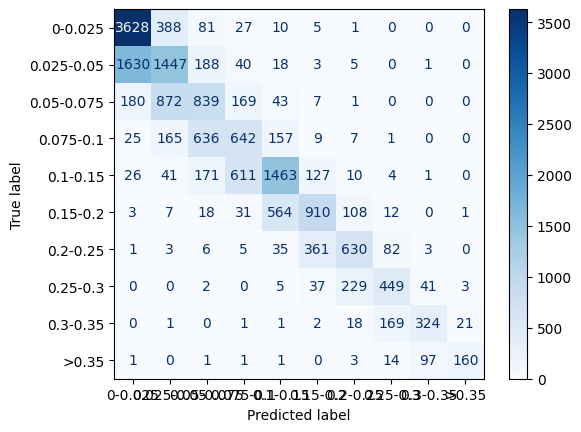

In [19]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
    X, y = X.to(device), y.to(device).view(-1, 1)
    y_pred = model(X)
    for i in range(len(X)):
        true_range = pd.cut([float(y[i])], bins=bins, labels=labels, include_lowest=True)[0]
        pred_range = pd.cut([float(y_pred[i])], bins=bins, labels=labels, include_lowest=True)[0]
        results_list.append({'true_range': str(true_range), 'pred_range': str(pred_range),'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])})


results_df = pd.DataFrame(results_list)

y_true = results_df['true_range']
y_pred = results_df['pred_range']
cm = confusion_matrix(y_true, y_pred, labels=labels)

print(f"Classification Report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels))


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

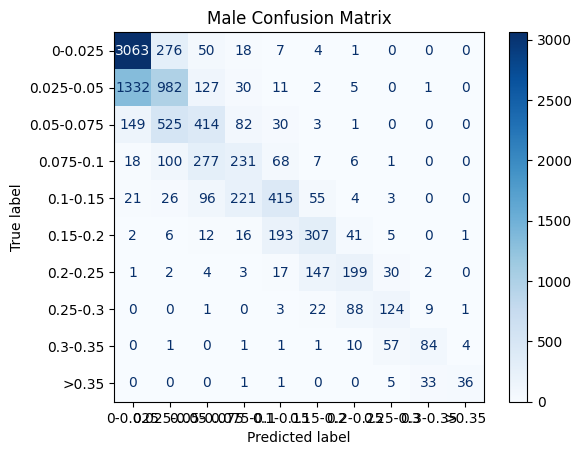

Classification Report for Male Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.67      0.57      0.61      5384
  0.025-0.05       0.51      0.39      0.44      2549
  0.05-0.075       0.42      0.34      0.38      1214
   0.075-0.1       0.38      0.33      0.35       710
    0.1-0.15       0.56      0.49      0.52       843
    0.15-0.2       0.56      0.53      0.54       583
    0.2-0.25       0.56      0.49      0.52       405
    0.25-0.3       0.55      0.50      0.52       248
    0.3-0.35       0.65      0.53      0.58       159
       >0.35       0.86      0.47      0.61        76

   micro avg       0.58      0.48      0.53     12171
   macro avg       0.57      0.46      0.51     12171
weighted avg       0.58      0.48      0.52     12171



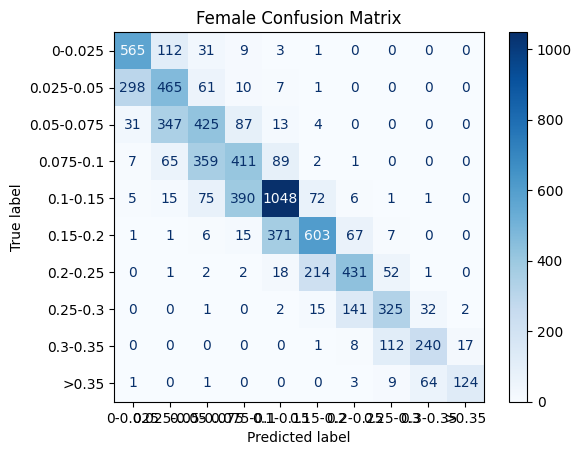

Classification Report for Female Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.62      0.62      0.62       904
  0.025-0.05       0.46      0.55      0.50       847
  0.05-0.075       0.44      0.47      0.45       908
   0.075-0.1       0.44      0.44      0.44       936
    0.1-0.15       0.68      0.65      0.66      1613
    0.15-0.2       0.66      0.56      0.61      1071
    0.2-0.25       0.66      0.60      0.63       721
    0.25-0.3       0.64      0.63      0.63       518
    0.3-0.35       0.71      0.63      0.67       378
       >0.35       0.87      0.61      0.72       202

   micro avg       0.59      0.57      0.58      8098
   macro avg       0.62      0.58      0.59      8098
weighted avg       0.60      0.57      0.58      8098

Male error:  0.0013617812376586636
Female error:  0.0010836677112585232


0.0015008380008587339

In [20]:
results_male = results_df.loc[results_df["gender"] > 0.5]
results_female = results_df.loc[results_df["gender"] < 0.5]
# print(results_male)
# print(results_female)

def plot_confusion_matrix(results, title):
    y_true = results['true_range']
    y_pred = results['pred_range']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()
    
    print(f"Classification Report for {title}:\n")
    print(classification_report(y_true, y_pred, labels=labels, target_names=labels))


# Male confusion matrix
plot_confusion_matrix(results_male, "Male Confusion Matrix")

# Female confusion matrix
plot_confusion_matrix(results_female, "Female Confusion Matrix")

metric_fn(results_male,results_female)

### Third step - weighted loss function - Gender Distribution

The histogramme also shows the gender differences between dataset(mainly on data distribution), so we tried to handel this problem by adding gender based weights in weighted loss function.

In [21]:
# Define gender weights
gender_counts = df_train['gender'].apply(lambda x: 'male' if x > 0.5 else 'female').value_counts()
total_gender_samples = len(df_train)
gender_weights = {'male': 1, 'female': 1.05}
print(gender_weights)


class WeightedMSELoss2(nn.Module):
    def __init__(self, range_weights, gender_weights):
        super(WeightedMSELoss2, self).__init__()
        self.range_weights = range_weights
        self.gender_weights = gender_weights
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, inputs, targets, ranges, genders):
        loss = self.mse(inputs, targets)
        range_weights = torch.tensor([self.range_weights[str(label)] for label in ranges], device=inputs.device)
        gender_weights = torch.tensor([self.gender_weights['male'] if gender > 0.5 else self.gender_weights['female'] for gender in genders], device=inputs.device)
        total_weights = range_weights * gender_weights
        weighted_loss = loss * total_weights
        return weighted_loss.mean()




{'male': 1, 'female': 1.05}


In [22]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

criterion = WeightedMSELoss2(range_weights, gender_weights)

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        
        ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)   
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y, ranges,gender)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


  0%|          | 1/10134 [00:00<27:01,  6.25it/s]

Batch 0, Loss: 2.796797037124634


 20%|█▉        | 2004/10134 [01:03<04:13, 32.06it/s]

Batch 2000, Loss: 0.016754090785980225


 40%|███▉      | 4004/10134 [02:06<03:15, 31.32it/s]

Batch 4000, Loss: 0.005950150080025196


 59%|█████▉    | 6006/10134 [03:09<02:10, 31.75it/s]

Batch 6000, Loss: 0.05484885722398758


 79%|███████▉  | 8006/10134 [04:12<01:06, 32.02it/s]

Batch 8000, Loss: 0.019411997869610786


 99%|█████████▊| 10006/10134 [05:14<00:03, 32.12it/s]

Batch 10000, Loss: 0.31073275208473206


100%|██████████| 10134/10134 [05:18<00:00, 31.77it/s]


Epoch [1/10], Loss: 0.04951673323197383
Epoch 2/10


  0%|          | 4/10134 [00:00<05:17, 31.92it/s]

Batch 0, Loss: 0.005384897813200951


 20%|█▉        | 2004/10134 [01:03<04:18, 31.47it/s]

Batch 2000, Loss: 0.07732734084129333


 40%|███▉      | 4004/10134 [02:06<03:11, 31.99it/s]

Batch 4000, Loss: 0.003182448912411928


 59%|█████▉    | 6004/10134 [03:09<02:09, 31.98it/s]

Batch 6000, Loss: 0.006154869683086872


 79%|███████▉  | 8004/10134 [04:11<01:07, 31.61it/s]

Batch 8000, Loss: 0.009244509972631931


 99%|█████████▊| 10004/10134 [05:15<00:04, 31.60it/s]

Batch 10000, Loss: 0.0016216834774240851


100%|██████████| 10134/10134 [05:19<00:00, 31.74it/s]


Epoch [2/10], Loss: 0.01396089010701735
Epoch 3/10


  0%|          | 4/10134 [00:00<05:18, 31.83it/s]

Batch 0, Loss: 0.02930597960948944


 20%|█▉        | 2004/10134 [01:03<04:15, 31.87it/s]

Batch 2000, Loss: 0.002690928988158703


 40%|███▉      | 4004/10134 [02:05<03:19, 30.75it/s]

Batch 4000, Loss: 0.003154598642140627


 59%|█████▉    | 6004/10134 [03:09<02:11, 31.30it/s]

Batch 6000, Loss: 0.0021540296729654074


 79%|███████▉  | 8004/10134 [04:12<01:07, 31.65it/s]

Batch 8000, Loss: 0.010585544630885124


 99%|█████████▊| 10004/10134 [05:15<00:04, 31.95it/s]

Batch 10000, Loss: 0.01877950131893158


100%|██████████| 10134/10134 [05:19<00:00, 31.71it/s]


Epoch [3/10], Loss: 0.010693102855176372
Epoch 4/10


  0%|          | 4/10134 [00:00<05:21, 31.51it/s]

Batch 0, Loss: 0.018881449475884438


 20%|█▉        | 2004/10134 [01:02<04:14, 31.90it/s]

Batch 2000, Loss: 0.010083462111651897


 40%|███▉      | 4004/10134 [02:06<03:14, 31.48it/s]

Batch 4000, Loss: 0.0011611620429903269


 59%|█████▉    | 6004/10134 [03:09<02:09, 32.00it/s]

Batch 6000, Loss: 0.009366855025291443


 79%|███████▉  | 8004/10134 [04:12<01:06, 31.82it/s]

Batch 8000, Loss: 0.028363605961203575


 99%|█████████▊| 10004/10134 [05:15<00:04, 31.92it/s]

Batch 10000, Loss: 0.0025834650732576847


100%|██████████| 10134/10134 [05:19<00:00, 31.68it/s]


Epoch [4/10], Loss: 0.00812438308213782
Epoch 5/10


  0%|          | 4/10134 [00:00<05:21, 31.54it/s]

Batch 0, Loss: 0.003180647036060691


 20%|█▉        | 2004/10134 [01:03<04:17, 31.58it/s]

Batch 2000, Loss: 0.018293282017111778


 40%|███▉      | 4004/10134 [02:07<03:12, 31.91it/s]

Batch 4000, Loss: 0.0020600748248398304


 59%|█████▉    | 6006/10134 [03:11<02:17, 30.12it/s]

Batch 6000, Loss: 0.003275110386312008


 79%|███████▉  | 8006/10134 [04:17<01:07, 31.45it/s]

Batch 8000, Loss: 0.002758448012173176


 99%|█████████▊| 10006/10134 [05:21<00:04, 31.34it/s]

Batch 10000, Loss: 0.005601690150797367


100%|██████████| 10134/10134 [05:25<00:00, 31.09it/s]


Epoch [5/10], Loss: 0.007032475440298361
Epoch 6/10


  0%|          | 3/10134 [00:00<05:43, 29.50it/s]

Batch 0, Loss: 0.0038582785055041313


 20%|█▉        | 2006/10134 [01:03<04:17, 31.55it/s]

Batch 2000, Loss: 0.0009384594159200788


 40%|███▉      | 4004/10134 [02:09<03:53, 26.25it/s]

Batch 4000, Loss: 0.003553571878001094


 59%|█████▉    | 6004/10134 [03:33<02:49, 24.34it/s]

Batch 6000, Loss: 0.012254050001502037


 79%|███████▉  | 8004/10134 [04:54<01:40, 21.16it/s]

Batch 8000, Loss: 0.0031160195358097553


 99%|█████████▊| 10006/10134 [06:16<00:04, 25.66it/s]

Batch 10000, Loss: 0.00820484571158886


100%|██████████| 10134/10134 [06:22<00:00, 26.51it/s]


Epoch [6/10], Loss: 0.00589694203471197
Epoch 7/10


  0%|          | 3/10134 [00:00<07:54, 21.36it/s]

Batch 0, Loss: 0.00328724249266088


 20%|█▉        | 2005/10134 [01:20<05:03, 26.79it/s]

Batch 2000, Loss: 0.00659768795594573


 40%|███▉      | 4003/10134 [02:40<04:13, 24.16it/s]

Batch 4000, Loss: 0.002259523142129183


 59%|█████▉    | 6006/10134 [04:01<02:54, 23.66it/s]

Batch 6000, Loss: 0.007091529667377472


 79%|███████▉  | 8004/10134 [05:23<01:15, 28.20it/s]

Batch 8000, Loss: 0.00236787972971797


 99%|█████████▊| 10003/10134 [06:43<00:06, 20.92it/s]

Batch 10000, Loss: 0.005865803454071283


100%|██████████| 10134/10134 [06:49<00:00, 24.76it/s]


Epoch [7/10], Loss: 0.005162593032555092
Epoch 8/10


  0%|          | 3/10134 [00:00<07:15, 23.25it/s]

Batch 0, Loss: 0.010330157354474068


 20%|█▉        | 2006/10134 [01:14<04:36, 29.38it/s]

Batch 2000, Loss: 0.00891802180558443


 40%|███▉      | 4004/10134 [02:19<03:20, 30.61it/s]

Batch 4000, Loss: 0.000562473142053932


 59%|█████▉    | 6005/10134 [03:24<02:16, 30.16it/s]

Batch 6000, Loss: 0.0011491021141409874


 79%|███████▉  | 8004/10134 [04:29<01:11, 29.82it/s]

Batch 8000, Loss: 0.0034930005203932524


 99%|█████████▊| 10006/10134 [05:34<00:04, 30.06it/s]

Batch 10000, Loss: 0.0015240934444591403


100%|██████████| 10134/10134 [05:38<00:00, 29.92it/s]


Epoch [8/10], Loss: 0.00456384804251288
Epoch 9/10


  0%|          | 3/10134 [00:00<06:33, 25.73it/s]

Batch 0, Loss: 0.0005428476724773645


 20%|█▉        | 2004/10134 [01:05<04:38, 29.16it/s]

Batch 2000, Loss: 0.00441212160512805


 40%|███▉      | 4004/10134 [02:11<03:23, 30.06it/s]

Batch 4000, Loss: 0.000582645763643086


 59%|█████▉    | 6005/10134 [03:16<02:20, 29.43it/s]

Batch 6000, Loss: 0.008242868818342686


 79%|███████▉  | 8004/10134 [04:22<01:10, 30.11it/s]

Batch 8000, Loss: 0.0010453318245708942


 99%|█████████▊| 10006/10134 [05:29<00:04, 30.62it/s]

Batch 10000, Loss: 0.0018550963141024113


100%|██████████| 10134/10134 [05:33<00:00, 30.40it/s]


Epoch [9/10], Loss: 0.004183442831805887
Epoch 10/10


  0%|          | 3/10134 [00:00<07:19, 23.05it/s]

Batch 0, Loss: 0.0019313868833705783


 20%|█▉        | 2004/10134 [01:05<04:24, 30.75it/s]

Batch 2000, Loss: 0.00021328477305360138


 40%|███▉      | 4003/10134 [02:11<03:21, 30.44it/s]

Batch 4000, Loss: 0.0009337951196357608


 59%|█████▉    | 6004/10134 [03:18<02:16, 30.20it/s]

Batch 6000, Loss: 0.0027311593294143677


 79%|███████▉  | 8004/10134 [04:24<01:09, 30.47it/s]

Batch 8000, Loss: 0.0020360120106488466


 99%|█████████▊| 10005/10134 [05:31<00:04, 29.97it/s]

Batch 10000, Loss: 0.003745605470612645


100%|██████████| 10134/10134 [05:35<00:00, 30.18it/s]

Epoch [10/10], Loss: 0.00363768790823582
Training complete


Several gender weights has been tested with 3 epochs running:  score | weights  

- 0.0025   {'male': 1.6632542108610466, 'female': 2.5077175291533917}(calculated by gender distribution)

- 0.0028   {'male': 1, 'female': 1.5}

- 0.0025   {'male': 1, 'female': 1.1}

- 0.0031   {'male': 1, 'female': 1.2}

- 0.00188 / 0.00437    {'male': 1, 'female': 1.05} 

- 0.0035   {'male': 1, 'female': 1.01}

- 0.0036   {'male': 1, 'female': 1.04}

- 0.00236   {'male': 1, 'female': 1.06}

- 0.003   {'male': 1, 'female': 1.055}

- 0.0037   {'male': 1, 'female': 1.08}

We can see that certain weight do optimise the performance but the result is not stable. It may because the introduction of gender weights changes the shape of the loss function and the current learning rate may be too high, causing the model to fluctuate during training and not converge. But we did not test the reduction of the learning rate as short of GPU resource. Another reason might because the gender weight made the loss weight too extreme for the model.

For {'male': 1, 'female': 1.05}, 10 epochs ended up with 0.003/0.0022 and 20 epochs ended up with 0.0024.

We also considered a weight with error calculation weight given by the texte, but results does not optimised.
range_weights = {label: (total_samples / count) * (1/30 + mean) for label, count, mean in zip(range_counts.index, range_counts.values, range_means.values)}
mean is the occlusions' mean for samples in this range.



100%|██████████| 2534/2534 [01:15<00:00, 33.44it/s]


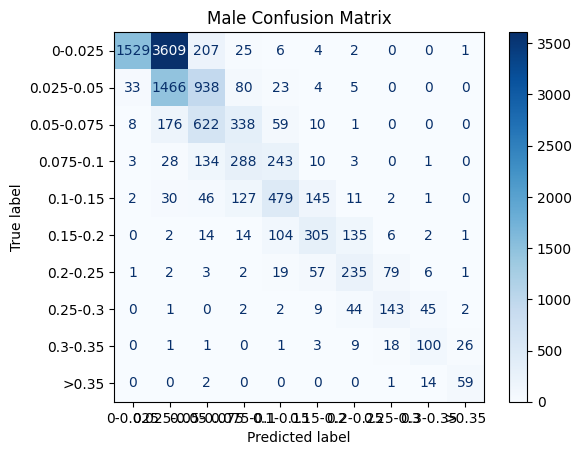

Classification Report for Male Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.97      0.28      0.44      5384
  0.025-0.05       0.28      0.58      0.37      2549
  0.05-0.075       0.32      0.51      0.39      1214
   0.075-0.1       0.33      0.41      0.36       710
    0.1-0.15       0.51      0.57      0.54       843
    0.15-0.2       0.56      0.52      0.54       583
    0.2-0.25       0.53      0.58      0.55       405
    0.25-0.3       0.57      0.58      0.58       248
    0.3-0.35       0.59      0.63      0.61       159
       >0.35       0.66      0.78      0.71        76

   micro avg       0.43      0.43      0.43     12171
   macro avg       0.53      0.54      0.51     12171
weighted avg       0.64      0.43      0.44     12171



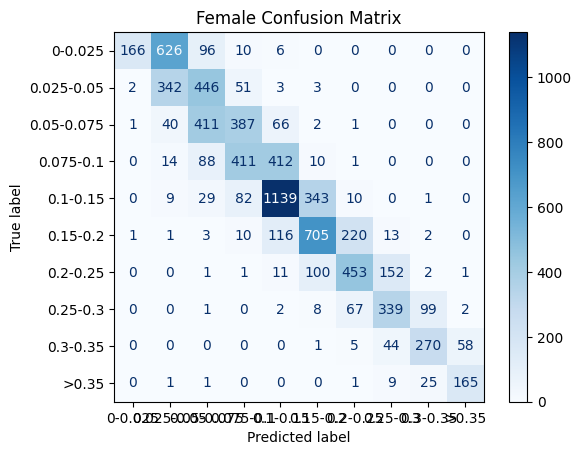

Classification Report for Female Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.98      0.18      0.31       904
  0.025-0.05       0.33      0.40      0.36       847
  0.05-0.075       0.38      0.45      0.41       908
   0.075-0.1       0.43      0.44      0.44       936
    0.1-0.15       0.65      0.71      0.68      1613
    0.15-0.2       0.60      0.66      0.63      1071
    0.2-0.25       0.60      0.63      0.61       721
    0.25-0.3       0.61      0.65      0.63       518
    0.3-0.35       0.68      0.71      0.69       378
       >0.35       0.73      0.82      0.77       202

    accuracy                           0.54      8098
   macro avg       0.60      0.57      0.55      8098
weighted avg       0.59      0.54      0.53      8098

Male error:  0.0012338898671285412
Female error:  0.001080491601409515


0.0013105889999880545

In [23]:
results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
    X, y = X.to(device), y.to(device).view(-1, 1)
    y_pred = model(X)
    for i in range(len(X)):
        true_range = pd.cut([float(y[i])], bins=bins, labels=labels, include_lowest=True)[0]
        pred_range = pd.cut([float(y_pred[i])], bins=bins, labels=labels, include_lowest=True)[0]
        results_list.append({'true_range': str(true_range), 'pred_range': str(pred_range),'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])})


results_df = pd.DataFrame(results_list)

results_male = results_df.loc[results_df["gender"] > 0.5]
results_female = results_df.loc[results_df["gender"] < 0.5]
# print(results_male)
# print(results_female)

def plot_confusion_matrix(results, title):
    y_true = results['true_range']
    y_pred = results['pred_range']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()
    
    print(f"Classification Report for {title}:\n")
    print(classification_report(y_true, y_pred, labels=labels, target_names=labels))


# Male confusion matrix
plot_confusion_matrix(results_male, "Male Confusion Matrix")

# Female confusion matrix
plot_confusion_matrix(results_female, "Female Confusion Matrix")

metric_fn(results_male,results_female)

### Fourth step - Fine-tuning and Drop out

#### Fine-Tuning

In [24]:
#  fine-tuning
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False

# Allow the parameters of the last layer (usually the classifier) to be updated (i.e., require gradients) 
# so that they can be adapted on new tasks to suit the specific requirements of the new data.

for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

criterion = WeightedMSELoss(range_weights)

optimizer = optim.Adam(model.parameters(), lr=1e-4)


num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)

        ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)
        
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y, ranges)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


  0%|          | 3/10134 [00:00<05:51, 28.85it/s]

Batch 0, Loss: 0.8864185810089111


 20%|█▉        | 2005/10134 [00:49<03:14, 41.80it/s]

Batch 2000, Loss: 0.069414421916008


 40%|███▉      | 4005/10134 [01:36<02:23, 42.56it/s]

Batch 4000, Loss: 0.1940552294254303


 59%|█████▉    | 6006/10134 [02:23<01:37, 42.50it/s]

Batch 6000, Loss: 0.1254347264766693


 79%|███████▉  | 8006/10134 [03:10<00:49, 43.24it/s]

Batch 8000, Loss: 0.03329400718212128


 99%|█████████▊| 10006/10134 [03:58<00:03, 42.41it/s]

Batch 10000, Loss: 0.08156552910804749


100%|██████████| 10134/10134 [04:01<00:00, 42.03it/s]


Epoch [1/10], Loss: 0.17495056513662172
Epoch 2/10


  0%|          | 5/10134 [00:00<04:04, 41.47it/s]

Batch 0, Loss: 0.060654472559690475


 20%|█▉        | 2005/10134 [00:47<03:11, 42.43it/s]

Batch 2000, Loss: 0.09573540091514587


 40%|███▉      | 4004/10134 [01:33<02:20, 43.55it/s]

Batch 4000, Loss: 0.01586376130580902


 59%|█████▉    | 6004/10134 [02:20<01:35, 43.33it/s]

Batch 6000, Loss: 0.07260657101869583


 79%|███████▉  | 8009/10134 [03:07<00:49, 43.28it/s]

Batch 8000, Loss: 0.028372490778565407


 99%|█████████▉| 10008/10134 [03:54<00:02, 42.38it/s]

Batch 10000, Loss: 0.06123311445116997


100%|██████████| 10134/10134 [03:57<00:00, 42.67it/s]


Epoch [2/10], Loss: 0.06267888142981375
Epoch 3/10


  0%|          | 4/10134 [00:00<04:14, 39.82it/s]

Batch 0, Loss: 0.0234324112534523


 20%|█▉        | 2004/10134 [00:47<03:10, 42.72it/s]

Batch 2000, Loss: 0.02898167073726654


 40%|███▉      | 4004/10134 [01:34<02:20, 43.51it/s]

Batch 4000, Loss: 0.04794798046350479


 59%|█████▉    | 6004/10134 [02:20<01:34, 43.77it/s]

Batch 6000, Loss: 0.01360255666077137


 79%|███████▉  | 8009/10134 [03:07<00:49, 43.16it/s]

Batch 8000, Loss: 0.05650552362203598


 99%|█████████▊| 10004/10134 [03:54<00:03, 42.69it/s]

Batch 10000, Loss: 0.017432603985071182


100%|██████████| 10134/10134 [03:57<00:00, 42.66it/s]


Epoch [3/10], Loss: 0.0578274117770627
Epoch 4/10


  0%|          | 5/10134 [00:00<04:10, 40.39it/s]

Batch 0, Loss: 0.03148355334997177


 20%|█▉        | 2005/10134 [00:47<03:14, 41.86it/s]

Batch 2000, Loss: 0.02403542399406433


 40%|███▉      | 4005/10134 [01:34<02:20, 43.75it/s]

Batch 4000, Loss: 0.06617234647274017


 59%|█████▉    | 6005/10134 [02:20<01:36, 42.89it/s]

Batch 6000, Loss: 0.1008119210600853


 79%|███████▉  | 8008/10134 [03:07<00:49, 43.08it/s]

Batch 8000, Loss: 0.4158373177051544


 99%|█████████▊| 10007/10134 [03:55<00:03, 42.06it/s]

Batch 10000, Loss: 0.04513203352689743


100%|██████████| 10134/10134 [03:58<00:00, 42.56it/s]


Epoch [4/10], Loss: 0.056324734714583685
Epoch 5/10


  0%|          | 5/10134 [00:00<03:56, 42.75it/s]

Batch 0, Loss: 0.6416652202606201


 20%|█▉        | 2005/10134 [00:47<03:14, 41.86it/s]

Batch 2000, Loss: 0.026595795527100563


 40%|███▉      | 4009/10134 [01:34<02:19, 43.89it/s]

Batch 4000, Loss: 0.045438677072525024


 59%|█████▉    | 6009/10134 [02:20<01:35, 43.24it/s]

Batch 6000, Loss: 0.19719606637954712


 79%|███████▉  | 8004/10134 [03:07<00:49, 43.11it/s]

Batch 8000, Loss: 0.3448680639266968


 99%|█████████▊| 10004/10134 [03:54<00:03, 42.76it/s]

Batch 10000, Loss: 0.02306217886507511


100%|██████████| 10134/10134 [03:57<00:00, 42.63it/s]


Epoch [5/10], Loss: 0.05526172138907428
Epoch 6/10


  0%|          | 5/10134 [00:00<04:05, 41.34it/s]

Batch 0, Loss: 0.5353847146034241


 20%|█▉        | 2005/10134 [00:47<03:13, 41.98it/s]

Batch 2000, Loss: 0.09931643307209015


 40%|███▉      | 4005/10134 [01:34<02:20, 43.59it/s]

Batch 4000, Loss: 0.03418644517660141


 59%|█████▉    | 6005/10134 [02:20<01:35, 43.16it/s]

Batch 6000, Loss: 0.2543208599090576


 79%|███████▉  | 8005/10134 [03:07<00:49, 43.08it/s]

Batch 8000, Loss: 0.03329111635684967


 99%|█████████▊| 10005/10134 [03:54<00:03, 41.89it/s]

Batch 10000, Loss: 0.02917352505028248


100%|██████████| 10134/10134 [03:57<00:00, 42.64it/s]


Epoch [6/10], Loss: 0.05532574773771982
Epoch 7/10


  0%|          | 5/10134 [00:00<04:03, 41.53it/s]

Batch 0, Loss: 0.01531373430043459


 20%|█▉        | 2005/10134 [00:47<03:08, 43.01it/s]

Batch 2000, Loss: 0.022827018052339554


 40%|███▉      | 4005/10134 [01:34<02:22, 43.06it/s]

Batch 4000, Loss: 0.1439952701330185


 59%|█████▉    | 6005/10134 [02:20<01:34, 43.62it/s]

Batch 6000, Loss: 0.024028649553656578


 79%|███████▉  | 8008/10134 [03:08<00:49, 43.05it/s]

Batch 8000, Loss: 0.030546482652425766


 99%|█████████▉| 10008/10134 [03:55<00:03, 41.03it/s]

Batch 10000, Loss: 0.08379776775836945


100%|██████████| 10134/10134 [03:58<00:00, 42.49it/s]


Epoch [7/10], Loss: 0.05561818938501725
Epoch 8/10


  0%|          | 4/10134 [00:00<04:16, 39.51it/s]

Batch 0, Loss: 0.11655817925930023


 20%|█▉        | 2004/10134 [00:47<03:09, 42.80it/s]

Batch 2000, Loss: 0.019586190581321716


 40%|███▉      | 4004/10134 [01:34<02:23, 42.62it/s]

Batch 4000, Loss: 0.017958179116249084


 59%|█████▉    | 6004/10134 [02:20<01:37, 42.38it/s]

Batch 6000, Loss: 0.009305247105658054


 79%|███████▉  | 8004/10134 [03:07<00:49, 42.96it/s]

Batch 8000, Loss: 0.0523032583296299


 99%|█████████▊| 10004/10134 [03:54<00:03, 42.31it/s]

Batch 10000, Loss: 0.05875677615404129


100%|██████████| 10134/10134 [03:57<00:00, 42.61it/s]


Epoch [8/10], Loss: 0.05526057830227339
Epoch 9/10


  0%|          | 5/10134 [00:00<04:07, 40.91it/s]

Batch 0, Loss: 0.03200463205575943


 20%|█▉        | 2004/10134 [00:47<03:12, 42.17it/s]

Batch 2000, Loss: 0.07847696542739868


 40%|███▉      | 4009/10134 [01:35<02:22, 43.00it/s]

Batch 4000, Loss: 0.02433834969997406


 59%|█████▉    | 6004/10134 [02:21<01:36, 42.96it/s]

Batch 6000, Loss: 0.07745829224586487


 79%|███████▉  | 8004/10134 [03:08<00:49, 43.07it/s]

Batch 8000, Loss: 0.03098750114440918


 99%|█████████▉| 10009/10134 [03:55<00:03, 41.10it/s]

Batch 10000, Loss: 0.08125035464763641


100%|██████████| 10134/10134 [03:58<00:00, 42.51it/s]


Epoch [9/10], Loss: 0.05576825611443941
Epoch 10/10


  0%|          | 5/10134 [00:00<04:01, 41.91it/s]

Batch 0, Loss: 0.010777304880321026


 20%|█▉        | 2005/10134 [00:47<03:11, 42.47it/s]

Batch 2000, Loss: 0.0706942230463028


 40%|███▉      | 4005/10134 [01:34<02:23, 42.86it/s]

Batch 4000, Loss: 0.08636059612035751


 59%|█████▉    | 6005/10134 [02:21<01:34, 43.55it/s]

Batch 6000, Loss: 0.14161622524261475


 79%|███████▉  | 8005/10134 [03:07<00:49, 42.91it/s]

Batch 8000, Loss: 0.005963347852230072


 99%|█████████▊| 10005/10134 [03:54<00:03, 42.37it/s]

Batch 10000, Loss: 0.01072392426431179


100%|██████████| 10134/10134 [03:57<00:00, 42.61it/s]

Epoch [10/10], Loss: 0.055033471810022425
Training complete


With range-based weight, fine-tuning result:  
epochs | score  
3 | 0.017            
50 | 0.0114  



With range-gender-based weight, gender weights {'male': 1, 'female': 1.05} fine-tuning result:  
epochs | score  
3 | 0.015  
10 | 0.024             
50 | 0.034   

100%|██████████| 2534/2534 [01:16<00:00, 33.13it/s]


Classification Report:

              precision    recall  f1-score   support

     0-0.025       0.54      0.18      0.28      6288
  0.025-0.05       0.23      0.20      0.21      3396
  0.05-0.075       0.14      0.20      0.17      2122
   0.075-0.1       0.12      0.21      0.15      1646
    0.1-0.15       0.22      0.35      0.27      2456
    0.15-0.2       0.22      0.25      0.23      1654
    0.2-0.25       0.20      0.15      0.17      1126
    0.25-0.3       0.23      0.08      0.12       766
    0.3-0.35       0.32      0.04      0.06       537
       >0.35       0.50      0.01      0.02       278

   micro avg       0.23      0.20      0.22     20269
   macro avg       0.27      0.17      0.17     20269
weighted avg       0.31      0.20      0.22     20269



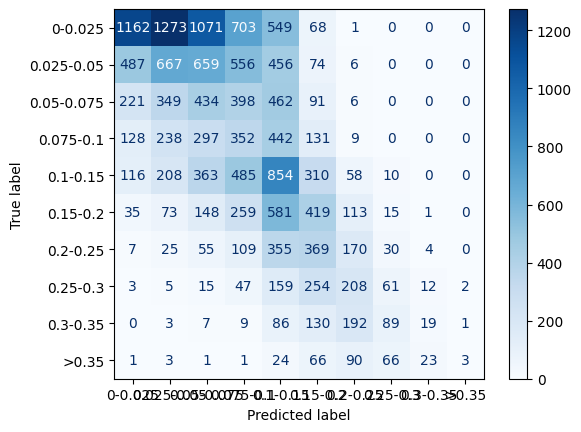

Male error:  0.008437590767417803
Female error:  0.006776256570554693


0.009268257865849358

In [25]:
results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
    X, y = X.to(device), y.to(device).view(-1, 1)
    y_pred = model(X)
    for i in range(len(X)):
        true_range = pd.cut([float(y[i])], bins=bins, labels=labels, include_lowest=True)[0]
        pred_range = pd.cut([float(y_pred[i])], bins=bins, labels=labels, include_lowest=True)[0]
        results_list.append({'true_range': str(true_range), 'pred_range': str(pred_range),'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])})


results_df = pd.DataFrame(results_list)

y_true = results_df['true_range']
y_pred = results_df['pred_range']
cm = confusion_matrix(y_true, y_pred, labels=labels)

print(f"Classification Report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels))


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

results_male = results_df.loc[results_df["gender"] > 0.5]
results_female = results_df.loc[results_df["gender"] < 0.5]

metric_fn(results_male,results_female)

Fine-tuning not really useful in this case

#### Drop out

In [26]:
#  drop out

model = models.resnet18(pretrained=True)

# Modify last layor to regression layor and add drop out
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # dropout layor, probability = 0.5
    nn.Linear(model.fc.in_features, 1)
)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = WeightedMSELoss(range_weights)


num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y, ranges)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


Epoch 1/10


c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 1/10134 [00:00<24:05,  7.01it/s]

Batch 0, Loss: 4.090895175933838


 20%|█▉        | 2006/10134 [01:05<04:21, 31.05it/s]

Batch 2000, Loss: 0.17994804680347443


 40%|███▉      | 4005/10134 [02:09<03:14, 31.53it/s]

Batch 4000, Loss: 0.21130570769309998


 59%|█████▉    | 6005/10134 [03:14<02:14, 30.64it/s]

Batch 6000, Loss: 0.021222276613116264


 79%|███████▉  | 8004/10134 [04:19<01:08, 30.91it/s]

Batch 8000, Loss: 0.04111737757921219


 99%|█████████▊| 10004/10134 [05:23<00:04, 30.66it/s]

Batch 10000, Loss: 0.009756926447153091


100%|██████████| 10134/10134 [05:28<00:00, 30.88it/s]


Epoch [1/10], Loss: 0.3559544328069384
Epoch 2/10


  0%|          | 4/10134 [00:00<05:25, 31.10it/s]

Batch 0, Loss: 0.00904329214245081


 20%|█▉        | 2007/10134 [01:05<04:24, 30.71it/s]

Batch 2000, Loss: 0.03999137133359909


 40%|███▉      | 4005/10134 [02:10<03:18, 30.80it/s]

Batch 4000, Loss: 0.009468497708439827


 59%|█████▉    | 6005/10134 [03:14<02:12, 31.15it/s]

Batch 6000, Loss: 0.01407063938677311


 79%|███████▉  | 8005/10134 [04:19<01:08, 30.87it/s]

Batch 8000, Loss: 0.07249222695827484


 99%|█████████▊| 10003/10134 [05:24<00:04, 30.85it/s]

Batch 10000, Loss: 0.0024445473682135344


100%|██████████| 10134/10134 [05:28<00:00, 30.82it/s]


Epoch [2/10], Loss: 0.0186025512152432
Epoch 3/10


  0%|          | 3/10134 [00:00<05:40, 29.79it/s]

Batch 0, Loss: 0.0025749588385224342


 20%|█▉        | 2007/10134 [01:05<04:25, 30.63it/s]

Batch 2000, Loss: 0.03693506121635437


 40%|███▉      | 4003/10134 [02:10<03:18, 30.91it/s]

Batch 4000, Loss: 0.0013782945461571217


 59%|█████▉    | 6006/10134 [03:15<02:17, 30.06it/s]

Batch 6000, Loss: 0.004908446222543716


 79%|███████▉  | 8005/10134 [04:20<01:08, 30.86it/s]

Batch 8000, Loss: 0.01309406477957964


 99%|█████████▊| 10005/10134 [05:25<00:04, 31.07it/s]

Batch 10000, Loss: 0.011228760704398155


100%|██████████| 10134/10134 [05:30<00:00, 30.71it/s]


Epoch [3/10], Loss: 0.014473734349882675
Epoch 4/10


  0%|          | 4/10134 [00:00<05:28, 30.85it/s]

Batch 0, Loss: 0.010534876957535744


 20%|█▉        | 2003/10134 [01:04<04:23, 30.82it/s]

Batch 2000, Loss: 0.001299283467233181


 40%|███▉      | 4006/10134 [02:09<03:20, 30.63it/s]

Batch 4000, Loss: 0.007231362164020538


 59%|█████▉    | 6003/10134 [03:15<02:14, 30.80it/s]

Batch 6000, Loss: 0.004848029464483261


 79%|███████▉  | 8003/10134 [04:19<01:09, 30.45it/s]

Batch 8000, Loss: 0.0021713259629905224


 99%|█████████▊| 10006/10134 [05:24<00:04, 30.22it/s]

Batch 10000, Loss: 0.001983954571187496


100%|██████████| 10134/10134 [05:28<00:00, 30.81it/s]


Epoch [4/10], Loss: 0.011346233514362803
Epoch 5/10


  0%|          | 4/10134 [00:00<05:31, 30.52it/s]

Batch 0, Loss: 0.00289705628529191


 20%|█▉        | 2004/10134 [01:05<04:25, 30.62it/s]

Batch 2000, Loss: 0.00463396031409502


 40%|███▉      | 4007/10134 [02:10<03:17, 31.00it/s]

Batch 4000, Loss: 0.007517671678215265


 59%|█████▉    | 6003/10134 [03:14<02:12, 31.12it/s]

Batch 6000, Loss: 0.01324515137821436


 79%|███████▉  | 8006/10134 [04:19<01:09, 30.57it/s]

Batch 8000, Loss: 0.0038083242252469063


 99%|█████████▊| 10005/10134 [05:24<00:04, 31.06it/s]

Batch 10000, Loss: 0.00831068679690361


100%|██████████| 10134/10134 [05:28<00:00, 30.83it/s]


Epoch [5/10], Loss: 0.010160558811722372
Epoch 6/10


  0%|          | 3/10134 [00:00<06:54, 24.43it/s]

Batch 0, Loss: 0.0019564516842365265


 20%|█▉        | 2005/10134 [01:05<04:25, 30.67it/s]

Batch 2000, Loss: 0.005409404635429382


 40%|███▉      | 4004/10134 [02:09<03:18, 30.90it/s]

Batch 4000, Loss: 0.0021480151917785406


 59%|█████▉    | 6004/10134 [03:14<02:15, 30.53it/s]

Batch 6000, Loss: 0.017537390813231468


 79%|███████▉  | 8006/10134 [04:19<01:10, 30.07it/s]

Batch 8000, Loss: 0.012668319046497345


 99%|█████████▊| 10003/10134 [05:24<00:04, 31.23it/s]

Batch 10000, Loss: 0.0036677082534879446


100%|██████████| 10134/10134 [05:28<00:00, 30.85it/s]


Epoch [6/10], Loss: 0.009109527838118707
Epoch 7/10


  0%|          | 4/10134 [00:00<05:26, 31.04it/s]

Batch 0, Loss: 0.01721765659749508


 20%|█▉        | 2004/10134 [01:04<04:24, 30.75it/s]

Batch 2000, Loss: 0.005429892335087061


 40%|███▉      | 4006/10134 [02:10<03:22, 30.22it/s]

Batch 4000, Loss: 0.004361993633210659


 59%|█████▉    | 6003/10134 [03:15<02:13, 30.94it/s]

Batch 6000, Loss: 0.004636895842850208


 79%|███████▉  | 8003/10134 [04:19<01:08, 31.27it/s]

Batch 8000, Loss: 0.015318334102630615


 99%|█████████▊| 10006/10134 [05:24<00:04, 30.73it/s]

Batch 10000, Loss: 0.01327238604426384


100%|██████████| 10134/10134 [05:28<00:00, 30.83it/s]


Epoch [7/10], Loss: 0.008309591212051427
Epoch 8/10


  0%|          | 4/10134 [00:00<05:30, 30.61it/s]

Batch 0, Loss: 0.006040487438440323


 20%|█▉        | 2007/10134 [01:05<04:24, 30.68it/s]

Batch 2000, Loss: 0.002037036931142211


 40%|███▉      | 4003/10134 [02:10<03:15, 31.43it/s]

Batch 4000, Loss: 0.003369359765201807


 59%|█████▉    | 6006/10134 [03:14<02:12, 31.05it/s]

Batch 6000, Loss: 0.00916822999715805


 79%|███████▉  | 8006/10134 [04:19<01:09, 30.67it/s]

Batch 8000, Loss: 0.0068313851952552795


 99%|█████████▊| 10005/10134 [05:24<00:04, 30.77it/s]

Batch 10000, Loss: 0.004940156824886799


100%|██████████| 10134/10134 [05:28<00:00, 30.82it/s]


Epoch [8/10], Loss: 0.0076316647472120525
Epoch 9/10


  0%|          | 4/10134 [00:00<05:31, 30.53it/s]

Batch 0, Loss: 0.002374810865148902


 20%|█▉        | 2004/10134 [01:04<04:28, 30.30it/s]

Batch 2000, Loss: 0.0033876411616802216


 40%|███▉      | 4006/10134 [02:09<03:18, 30.84it/s]

Batch 4000, Loss: 0.006434306968003511


 59%|█████▉    | 6006/10134 [03:14<02:13, 30.90it/s]

Batch 6000, Loss: 0.012627162970602512


 79%|███████▉  | 8006/10134 [04:19<01:09, 30.73it/s]

Batch 8000, Loss: 0.0008438584627583623


 99%|█████████▊| 10005/10134 [05:24<00:04, 31.32it/s]

Batch 10000, Loss: 0.0012933508260175586


100%|██████████| 10134/10134 [05:28<00:00, 30.87it/s]


Epoch [9/10], Loss: 0.006640863755599678
Epoch 10/10


  0%|          | 4/10134 [00:00<05:22, 31.37it/s]

Batch 0, Loss: 0.0015489514917135239


 20%|█▉        | 2003/10134 [01:05<04:33, 29.76it/s]

Batch 2000, Loss: 0.0023674392141401768


 40%|███▉      | 4005/10134 [02:10<03:16, 31.21it/s]

Batch 4000, Loss: 0.004308221861720085


 59%|█████▉    | 6004/10134 [03:15<02:12, 31.24it/s]

Batch 6000, Loss: 0.015872862190008163


 79%|███████▉  | 8004/10134 [04:19<01:08, 30.98it/s]

Batch 8000, Loss: 0.00855865515768528


 99%|█████████▊| 10007/10134 [05:25<00:04, 30.52it/s]

Batch 10000, Loss: 0.010106965899467468


100%|██████████| 10134/10134 [05:30<00:00, 30.70it/s]

Epoch [10/10], Loss: 0.005867552860293945
Training complete


With range-based weight, fine-tuning result:  
epochs | score  
3 | 0.00455            
10 | 0.00457    
20 | 0.002559

100%|██████████| 2534/2534 [01:14<00:00, 33.87it/s]


Classification Report:

              precision    recall  f1-score   support

     0-0.025       0.73      0.61      0.67      6288
  0.025-0.05       0.45      0.49      0.47      3396
  0.05-0.075       0.42      0.41      0.42      2122
   0.075-0.1       0.40      0.37      0.39      1646
    0.1-0.15       0.61      0.60      0.60      2456
    0.15-0.2       0.58      0.53      0.56      1654
    0.2-0.25       0.53      0.53      0.53      1126
    0.25-0.3       0.49      0.47      0.48       766
    0.3-0.35       0.52      0.42      0.46       537
       >0.35       0.69      0.43      0.53       278

   micro avg       0.56      0.52      0.54     20269
   macro avg       0.54      0.49      0.51     20269
weighted avg       0.57      0.52      0.55     20269



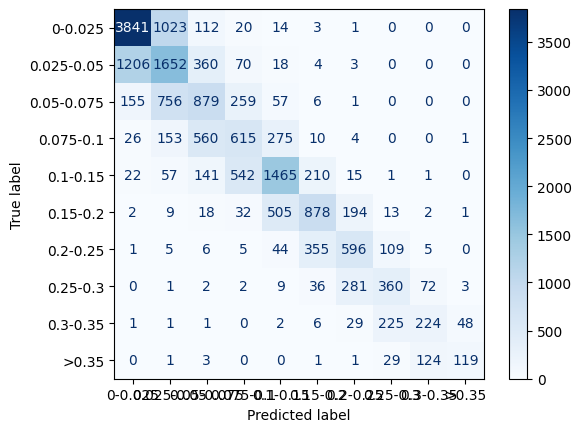

Male error:  0.0014830261229197557
Female error:  0.0013475463384588259


0.0015507660151502206

In [27]:
results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
    X, y = X.to(device), y.to(device).view(-1, 1)
    y_pred = model(X)
    for i in range(len(X)):
        true_range = pd.cut([float(y[i])], bins=bins, labels=labels, include_lowest=True)[0]
        pred_range = pd.cut([float(y_pred[i])], bins=bins, labels=labels, include_lowest=True)[0]
        results_list.append({'true_range': str(true_range), 'pred_range': str(pred_range),'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])})


results_df = pd.DataFrame(results_list)

y_true = results_df['true_range']
y_pred = results_df['pred_range']
cm = confusion_matrix(y_true, y_pred, labels=labels)

print(f"Classification Report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels))


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

results_male = results_df.loc[results_df["gender"] > 0.5]
results_female = results_df.loc[results_df["gender"] < 0.5]

metric_fn(results_male,results_female)

Does have optimization affect with augmentation the epoch but score lower than normal model without dropout

### Fifth step - 2 model black and white / color

In [28]:

from PIL import Image
import numpy as np

# Verify if the image is a grayscale image or not.
# If the values of R, G and B channels are equal, it means that the image is a grey scale map
def is_grayscale(image_path):
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)
    if np.array_equal(img_np[..., 0], img_np[..., 1]) and np.array_equal(img_np[..., 0], img_np[..., 2]):
        return True
    return False

# grayscale image = True, coloful image = False
df_train['is_grayscale'] = df_train['filename'].apply(lambda x: is_grayscale(f"{image_dir}/{x}"))

# split dataset grayscale and dataset colorful
df_train_grayscale = df_train[df_train['is_grayscale']]
df_train_color = df_train[~df_train['is_grayscale']]

# clean is_grayscale column
df_train_grayscale.drop(columns=['is_grayscale'], inplace=True)
df_train_color.drop(columns=['is_grayscale'], inplace=True)



C:\Users\ASUS\AppData\Local\Temp\ipykernel_4988\908790777.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_grayscale.drop(columns=['is_grayscale'], inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4988\908790777.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_color.drop(columns=['is_grayscale'], inplace=True)


In [29]:
df_train_grayscale.head()

,filename,FaceOcclusion,gender,range
6,database3/database3/m.01dmm2/6-FaceId-0_align.jpg,0.227,0.000,0.2-0.25
14,database3/database3/m.019pkm/91-FaceId-0_align...,0.016,0.994,0-0.025
17,database3/database3/m.0183dl/55-FaceId-0_align...,0.209,0.998,0.2-0.25
30,database3/database3/m.0197gg/7-FaceId-0_align.jpg,0.088,1.000,0.075-0.1
41,database3/database3/m.015t_m/70-FaceId-0_align...,0.001,0.982,0-0.025


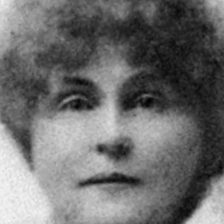

database3/database3/m.01dmm2/6-FaceId-0_align.jpg 0.227 0.0


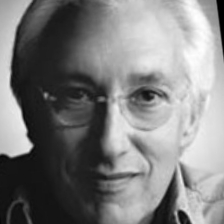

database3/database3/m.019pkm/91-FaceId-0_align.jpg 0.016 0.994


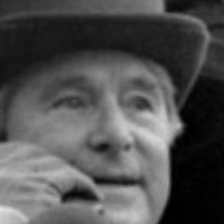

database3/database3/m.0183dl/55-FaceId-0_align.jpg 0.209 0.998


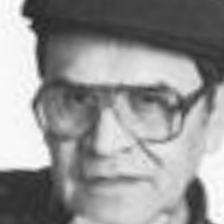

database3/database3/m.0197gg/7-FaceId-0_align.jpg 0.088 1.0


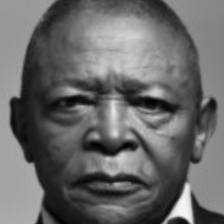

database3/database3/m.015t_m/70-FaceId-0_align.jpg 0.001 0.982


In [30]:
for idx, row in df_train_grayscale[:5].iterrows():
    filename = row['filename']
    occlusion = row['FaceOcclusion']
    gender = row['gender']
    img2display = Image.open(f"{image_dir}/{filename}")
    display(img2display)
    print(filename, occlusion, gender)

In [31]:
df_train_color.head()

,filename,FaceOcclusion,gender,range
0,database1/img00015966.jpg,0.015,0.997,0-0.025
1,database3/database3/m.01bczm/134-FaceId-0_alig...,0.011,0.998,0-0.025
2,database3/database3/m.01bldq/0-FaceId-0_align.jpg,0.071,0.997,0.05-0.075
3,database1/img00017957.jpg,0.351,0.001,>0.35
4,database1/img00020727.jpg,0.128,0.001,0.1-0.15


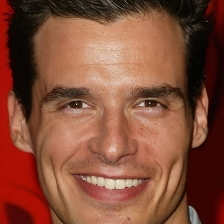

database1/img00015966.jpg 0.015 0.997


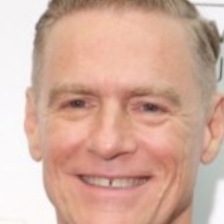

database3/database3/m.01bczm/134-FaceId-0_align.jpg 0.011 0.998


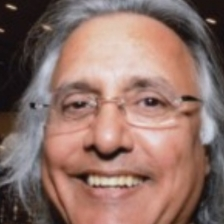

database3/database3/m.01bldq/0-FaceId-0_align.jpg 0.071 0.997


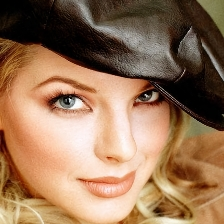

database1/img00017957.jpg 0.351 0.001


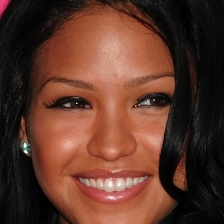

database1/img00020727.jpg 0.128 0.001


In [32]:
for idx, row in df_train_color[:5].iterrows():
    filename = row['filename']
    occlusion = row['FaceOcclusion']
    gender = row['gender']
    img2display = Image.open(f"{image_dir}/{filename}")
    display(img2display)
    print(filename, occlusion, gender)

In [33]:
df_train_grayscale = df_train_grayscale.reset_index(drop=True)
df_train_color= df_train_color.reset_index(drop=True)

In [34]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")
        y = row['FaceOcclusion']
        gender = row['gender']

        X = self.transform(img)
        y = np.float32(y)

        return X, y, gender, filename
    
    
    
params_train = {'batch_size': 8,
          'shuffle': True,
          'num_workers': 0}


train_grayscale_dataset = Dataset(df_train_grayscale, image_dir)
train_color_dataset = Dataset(df_train_color, image_dir)

train_grayscale_loader = torch.utils.data.DataLoader(train_grayscale_dataset, **params_train)
train_color_loader = torch.utils.data.DataLoader(train_color_dataset, **params_train)

In [35]:
bins = [0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 1.0]
labels = ['0-0.025', '0.025-0.05', '0.05-0.075', '0.075-0.1', '0.1-0.15', '0.15-0.2', '0.2-0.25', '0.25-0.3', '0.3-0.35', '>0.35']


df_train_grayscale['range'] = pd.cut(df_train_grayscale['FaceOcclusion'], bins=bins, labels=labels, include_lowest=True)
range_counts_G = df_train_grayscale['range'].value_counts().sort_index()
print(range_counts_G)

df_train_color['range'] = pd.cut(df_train_color['FaceOcclusion'], bins=bins, labels=labels, include_lowest=True)
range_counts = df_train_color['range'].value_counts().sort_index()
print(range_counts)


total_samples_G = len(df_train_grayscale)
total_samples = len(df_train_color)

range_weights_G = {label: 0.1*total_samples_G / count for label, count in range_counts_G.items()}
print("Weights for grayscale dataset")
print(range_weights_G)

range_weights = {label: 0.1*total_samples / count for label, count in range_counts.items()}
print("Weights for color dataset")
print(range_weights)

0-0.025       4336
0.025-0.05    2150
0.05-0.075    1150
0.075-0.1      850
0.1-0.15      1121
0.15-0.2       684
0.2-0.25       453
0.25-0.3       314
0.3-0.35       140
>0.35           70
Name: range, dtype: int64
0-0.025       21368
0.025-0.05    11388
0.05-0.075     7166
0.075-0.1      5713
0.1-0.15       8945
0.15-0.2       5849
0.2-0.25       3832
0.25-0.3       2767
0.3-0.35       1729
>0.35          1047
Name: range, dtype: int64
Weights for grayscale dataset
{'0-0.025': 0.2598708487084871, '0.025-0.05': 0.524093023255814, '0.05-0.075': 0.9798260869565217, '0.075-0.1': 1.3256470588235294, '0.1-0.15': 1.0051739518287244, '0.15-0.2': 1.6473684210526316, '0.2-0.25': 2.487417218543046, '0.25-0.3': 3.5885350318471336, '0.3-0.35': 8.048571428571428, '>0.35': 16.097142857142856}
Weights for color dataset
{'0-0.025': 0.3266754024709847, '0.025-0.05': 0.6129610115911486, '0.05-0.075': 0.9740999162712811, '0.075-0.1': 1.221844915105899, '0.1-0.15': 0.7803689211850197, '0.15-0.2': 1.19343

In [36]:
model_grayscale = models.resnet18(pretrained=True)
model_grayscale.fc = nn.Linear(model_grayscale.fc.in_features, 1)
model_grayscale = model_grayscale.to(device)


# Loss function for grayscale model
criterion1 = WeightedMSELoss(range_weights_G)
# Loss function for color model
criterion2 = WeightedMSELoss(range_weights)

optimizer_grayscale = optim.Adam(model_grayscale.parameters(), lr=1e-4)


# Grayscale model training
num_epochs = 15
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model_grayscale.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(train_grayscale_loader), total=len(train_grayscale_loader)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        
        ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)
        
        optimizer_grayscale.zero_grad()
        y_pred = model_grayscale(X)
        #loss = criterion2(y_pred, y, ranges,gender)

        loss = criterion1(y_pred, y, ranges)

        loss.backward()
        optimizer_grayscale.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_grayscale_loader)}")

print('Training complete for grayscale images')




c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15


  0%|          | 4/1409 [00:00<02:02, 11.49it/s]

Batch 0, Loss: 0.2846342623233795


100%|██████████| 1409/1409 [00:45<00:00, 31.13it/s]


Epoch [1/15], Loss: 0.023024900690092248
Epoch 2/15


  0%|          | 4/1409 [00:00<00:44, 31.32it/s]

Batch 0, Loss: 0.0022442061454057693


100%|██████████| 1409/1409 [00:44<00:00, 31.72it/s]


Epoch [2/15], Loss: 0.004116161717863712
Epoch 3/15


  0%|          | 4/1409 [00:00<00:46, 30.41it/s]

Batch 0, Loss: 0.003301631659269333


100%|██████████| 1409/1409 [00:44<00:00, 31.40it/s]


Epoch [3/15], Loss: 0.0028142749198951686
Epoch 4/15


  0%|          | 4/1409 [00:00<00:44, 31.78it/s]

Batch 0, Loss: 0.005585637874901295


100%|██████████| 1409/1409 [00:44<00:00, 31.46it/s]


Epoch [4/15], Loss: 0.0024685149227789186
Epoch 5/15


  0%|          | 4/1409 [00:00<00:43, 31.95it/s]

Batch 0, Loss: 0.0005979851121082902


100%|██████████| 1409/1409 [00:44<00:00, 31.66it/s]


Epoch [5/15], Loss: 0.0018697982091046678
Epoch 6/15


  0%|          | 4/1409 [00:00<00:43, 32.37it/s]

Batch 0, Loss: 0.00021636516612488776


100%|██████████| 1409/1409 [00:44<00:00, 31.81it/s]


Epoch [6/15], Loss: 0.001809694417184708
Epoch 7/15


  0%|          | 4/1409 [00:00<00:44, 31.62it/s]

Batch 0, Loss: 0.0003831571084447205


100%|██████████| 1409/1409 [00:44<00:00, 31.73it/s]


Epoch [7/15], Loss: 0.0015622839949195097
Epoch 8/15


  0%|          | 4/1409 [00:00<00:44, 31.73it/s]

Batch 0, Loss: 0.00011211460514459759


100%|██████████| 1409/1409 [00:44<00:00, 31.55it/s]


Epoch [8/15], Loss: 0.0016370655393494063
Epoch 9/15


  0%|          | 4/1409 [00:00<00:44, 31.64it/s]

Batch 0, Loss: 0.0025528271216899157


100%|██████████| 1409/1409 [00:44<00:00, 31.47it/s]


Epoch [9/15], Loss: 0.001294502796378079
Epoch 10/15


  0%|          | 4/1409 [00:00<00:44, 31.84it/s]

Batch 0, Loss: 0.0001392104895785451


100%|██████████| 1409/1409 [00:44<00:00, 31.36it/s]


Epoch [10/15], Loss: 0.001417575981102667
Epoch 11/15


  0%|          | 4/1409 [00:00<00:43, 32.38it/s]

Batch 0, Loss: 0.0011116692330688238


100%|██████████| 1409/1409 [00:44<00:00, 31.69it/s]


Epoch [11/15], Loss: 0.0012570850033014624
Epoch 12/15


  0%|          | 4/1409 [00:00<00:43, 32.22it/s]

Batch 0, Loss: 0.0013737259432673454


100%|██████████| 1409/1409 [00:44<00:00, 31.75it/s]


Epoch [12/15], Loss: 0.0007703362666595322
Epoch 13/15


  0%|          | 4/1409 [00:00<00:43, 32.01it/s]

Batch 0, Loss: 0.00032092537730932236


100%|██████████| 1409/1409 [00:45<00:00, 31.31it/s]


Epoch [13/15], Loss: 0.0010007202282679816
Epoch 14/15


  0%|          | 4/1409 [00:00<00:45, 30.79it/s]

Batch 0, Loss: 0.00037428189534693956


100%|██████████| 1409/1409 [00:44<00:00, 31.33it/s]


Epoch [14/15], Loss: 0.0007541068035840189
Epoch 15/15


  0%|          | 4/1409 [00:00<00:44, 31.70it/s]

Batch 0, Loss: 0.0023154565133154392


100%|██████████| 1409/1409 [00:44<00:00, 31.41it/s]

Epoch [15/15], Loss: 0.0008346680677250507
Training complete for grayscale images


In [37]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Color model training

model_color = models.resnet18(pretrained=True)
model_color.fc = nn.Linear(model_color.fc.in_features, 1)
model_color = model_color.to(device)

criterion2 = WeightedMSELoss(range_weights)

optimizer_color = optim.Adam(model_color.parameters(), lr=1e-4)

num_epochs = 15
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model_color.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(train_color_loader), total=len(train_color_loader)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)

        optimizer_color.zero_grad()
        y_pred = model_color(X)
        #loss = criterion2(y_pred, y, ranges,gender)
        loss = criterion2(y_pred, y, range_weights)
        loss.backward()
        optimizer_color.step()
        running_loss += loss.item()
        
        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_color_loader)}")

print('Training complete for color images')

c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15


  0%|          | 0/8726 [00:00<?, ?it/s]

Batch 0, Loss: 1.0757917165756226

  0%|          | 3/8726 [00:00<05:05, 28.55it/s]

 23%|██▎       | 2005/8726 [01:05<03:36, 31.06it/s]

Batch 2000, Loss: 0.003083073068410158


 46%|████▌     | 4005/8726 [02:10<02:32, 31.02it/s]

Batch 4000, Loss: 0.0016440859762951732


 69%|██████▉   | 6005/8726 [03:15<01:28, 30.60it/s]

Batch 6000, Loss: 0.0048728929832577705


 92%|█████████▏| 8007/8726 [04:20<00:23, 30.86it/s]

Batch 8000, Loss: 0.0003129382384940982


100%|██████████| 8726/8726 [04:44<00:00, 30.70it/s]


Epoch [1/15], Loss: 0.009009502890149432
Epoch 2/15


  0%|          | 4/8726 [00:00<04:42, 30.82it/s]

Batch 0, Loss: 0.0029208825435489416


 23%|██▎       | 2003/8726 [01:04<03:46, 29.62it/s]

Batch 2000, Loss: 0.001727467286400497


 46%|████▌     | 4005/8726 [02:10<02:36, 30.16it/s]

Batch 4000, Loss: 0.00141124427318573


 69%|██████▉   | 6005/8726 [03:15<01:28, 30.67it/s]

Batch 6000, Loss: 0.0005588908679783344


 92%|█████████▏| 8006/8726 [04:22<00:23, 30.15it/s]

Batch 8000, Loss: 0.0010942774824798107


100%|██████████| 8726/8726 [04:46<00:00, 30.49it/s]


Epoch [2/15], Loss: 0.002289581956852774
Epoch 3/15


  0%|          | 3/8726 [00:00<05:10, 28.06it/s]

Batch 0, Loss: 0.0005727317184209824


 23%|██▎       | 2004/8726 [01:07<03:44, 29.92it/s]

Batch 2000, Loss: 0.0011079870164394379


 46%|████▌     | 4005/8726 [02:15<02:43, 28.93it/s]

Batch 4000, Loss: 0.0011700306786224246


 69%|██████▉   | 6004/8726 [03:22<01:33, 29.23it/s]

Batch 6000, Loss: 0.0010634183418005705


 92%|█████████▏| 8006/8726 [04:30<00:24, 29.54it/s]

Batch 8000, Loss: 0.0012524196645244956


100%|██████████| 8726/8726 [04:54<00:00, 29.61it/s]


Epoch [3/15], Loss: 0.0017057432803881344
Epoch 4/15


  0%|          | 3/8726 [00:00<04:56, 29.47it/s]

Batch 0, Loss: 0.001943930285051465


 23%|██▎       | 2005/8726 [01:07<03:43, 30.09it/s]

Batch 2000, Loss: 0.0004155609349254519


 46%|████▌     | 4006/8726 [02:13<02:32, 30.88it/s]

Batch 4000, Loss: 0.0004703693266492337


 69%|██████▉   | 6006/8726 [03:18<01:28, 30.60it/s]

Batch 6000, Loss: 0.0008530067279934883


 92%|█████████▏| 8004/8726 [04:23<00:23, 30.32it/s]

Batch 8000, Loss: 0.00029046396957710385


100%|██████████| 8726/8726 [04:47<00:00, 30.40it/s]


Epoch [4/15], Loss: 0.0013050762348947237
Epoch 5/15


  0%|          | 3/8726 [00:00<04:52, 29.82it/s]

Batch 0, Loss: 7.426310185110196e-05


 23%|██▎       | 2003/8726 [01:05<03:37, 30.95it/s]

Batch 2000, Loss: 0.0012971031246706843


 46%|████▌     | 4006/8726 [02:10<02:31, 31.19it/s]

Batch 4000, Loss: 0.0012716964120045304


 69%|██████▉   | 6005/8726 [03:15<01:28, 30.64it/s]

Batch 6000, Loss: 0.0014384903479367495


 92%|█████████▏| 8006/8726 [04:20<00:23, 30.44it/s]

Batch 8000, Loss: 0.00017901485261972994


100%|██████████| 8726/8726 [04:44<00:00, 30.70it/s]


Epoch [5/15], Loss: 0.0010953819184779557
Epoch 6/15


  0%|          | 4/8726 [00:00<04:42, 30.92it/s]

Batch 0, Loss: 0.0006062751053832471


 23%|██▎       | 2004/8726 [01:04<03:37, 30.95it/s]

Batch 2000, Loss: 0.0011012282921001315


 46%|████▌     | 4004/8726 [02:09<02:33, 30.86it/s]

Batch 4000, Loss: 0.002374541014432907


 69%|██████▉   | 6004/8726 [03:14<01:29, 30.39it/s]

Batch 6000, Loss: 0.00047421647468581796


 92%|█████████▏| 8005/8726 [04:20<00:23, 30.96it/s]

Batch 8000, Loss: 0.0005357739864848554


100%|██████████| 8726/8726 [04:43<00:00, 30.79it/s]


Epoch [6/15], Loss: 0.0009176000602555385
Epoch 7/15


  0%|          | 4/8726 [00:00<04:36, 31.54it/s]

Batch 0, Loss: 0.0003642706433311105


 23%|██▎       | 2003/8726 [01:04<03:39, 30.60it/s]

Batch 2000, Loss: 0.00037533717113547027


 46%|████▌     | 4006/8726 [02:09<02:34, 30.61it/s]

Batch 4000, Loss: 0.0006805054727010429


 69%|██████▉   | 6006/8726 [03:15<01:27, 31.00it/s]

Batch 6000, Loss: 0.00037364219315350056


 92%|█████████▏| 8005/8726 [04:19<00:23, 31.19it/s]

Batch 8000, Loss: 0.0010066562099382281


100%|██████████| 8726/8726 [04:43<00:00, 30.81it/s]


Epoch [7/15], Loss: 0.0007704133525172571
Epoch 8/15


  0%|          | 3/8726 [00:00<04:51, 29.96it/s]

Batch 0, Loss: 0.0056011490523815155


 23%|██▎       | 2003/8726 [01:04<03:36, 31.12it/s]

Batch 2000, Loss: 0.0003969007811974734


 46%|████▌     | 4005/8726 [02:10<02:33, 30.72it/s]

Batch 4000, Loss: 0.0004894274170510471


 69%|██████▉   | 6004/8726 [03:15<01:27, 31.17it/s]

Batch 6000, Loss: 0.0008683513733558357


 92%|█████████▏| 8004/8726 [04:20<00:23, 31.12it/s]

Batch 8000, Loss: 0.0005180331063456833


100%|██████████| 8726/8726 [04:44<00:00, 30.71it/s]


Epoch [8/15], Loss: 0.0006766043740855892
Epoch 9/15


  0%|          | 4/8726 [00:00<04:43, 30.82it/s]

Batch 0, Loss: 0.00044995962525717914


 23%|██▎       | 2005/8726 [01:05<03:39, 30.60it/s]

Batch 2000, Loss: 0.00031789534841664135


 46%|████▌     | 4006/8726 [02:10<02:32, 30.99it/s]

Batch 4000, Loss: 6.872758240206167e-05


 69%|██████▉   | 6006/8726 [03:15<01:27, 31.08it/s]

Batch 6000, Loss: 0.0009324078564532101


 92%|█████████▏| 8004/8726 [04:20<00:23, 30.95it/s]

Batch 8000, Loss: 0.00018942049064207822


100%|██████████| 8726/8726 [04:43<00:00, 30.76it/s]


Epoch [9/15], Loss: 0.0005678246845377414
Epoch 10/15


  0%|          | 4/8726 [00:00<04:46, 30.39it/s]

Batch 0, Loss: 0.00016121593944262713


 23%|██▎       | 2003/8726 [01:05<03:37, 30.88it/s]

Batch 2000, Loss: 0.000409845873946324


 46%|████▌     | 4003/8726 [02:10<02:32, 31.05it/s]

Batch 4000, Loss: 0.0006997543387115002


 69%|██████▉   | 6006/8726 [03:15<01:27, 31.01it/s]

Batch 6000, Loss: 0.00010545772965997458


 92%|█████████▏| 8004/8726 [04:20<00:23, 30.43it/s]

Batch 8000, Loss: 0.00017755663429852575


100%|██████████| 8726/8726 [04:43<00:00, 30.74it/s]


Epoch [10/15], Loss: 0.0005207939307357612
Epoch 11/15


  0%|          | 4/8726 [00:00<04:46, 30.49it/s]

Batch 0, Loss: 0.0011320639168843627


 23%|██▎       | 2005/8726 [01:05<03:38, 30.76it/s]

Batch 2000, Loss: 0.0004512780869845301


 46%|████▌     | 4004/8726 [02:10<02:34, 30.54it/s]

Batch 4000, Loss: 0.00015996342699509114


 69%|██████▉   | 6003/8726 [03:15<01:29, 30.56it/s]

Batch 6000, Loss: 0.0014588290359824896


 92%|█████████▏| 8005/8726 [04:20<00:23, 30.88it/s]

Batch 8000, Loss: 0.000131698208861053


100%|██████████| 8726/8726 [04:44<00:00, 30.69it/s]


Epoch [11/15], Loss: 0.0004736853985301108
Epoch 12/15


  0%|          | 4/8726 [00:00<04:43, 30.76it/s]

Batch 0, Loss: 0.000669848348479718


 23%|██▎       | 2004/8726 [01:04<03:35, 31.13it/s]

Batch 2000, Loss: 8.144755702232942e-05


 46%|████▌     | 4003/8726 [02:09<02:34, 30.55it/s]

Batch 4000, Loss: 0.0005218712030909956


 69%|██████▉   | 6006/8726 [03:15<01:28, 30.66it/s]

Batch 6000, Loss: 0.00037228522705845535


 92%|█████████▏| 8005/8726 [04:20<00:23, 30.58it/s]

Batch 8000, Loss: 0.00018221366917714477


100%|██████████| 8726/8726 [04:43<00:00, 30.76it/s]


Epoch [12/15], Loss: 0.00040214567384556536
Epoch 13/15


  0%|          | 3/8726 [00:00<06:17, 23.11it/s]

Batch 0, Loss: 0.0003908277431037277


 23%|██▎       | 2003/8726 [01:04<03:37, 30.90it/s]

Batch 2000, Loss: 0.0005301972269080579


 46%|████▌     | 4006/8726 [02:10<02:33, 30.75it/s]

Batch 4000, Loss: 0.0013584187254309654


 69%|██████▉   | 6006/8726 [03:15<01:28, 30.73it/s]

Batch 6000, Loss: 0.00021188460232224315


 92%|█████████▏| 8006/8726 [04:20<00:23, 30.97it/s]

Batch 8000, Loss: 0.0004721702716778964


100%|██████████| 8726/8726 [04:43<00:00, 30.78it/s]


Epoch [13/15], Loss: 0.00038273038856732894
Epoch 14/15


  0%|          | 4/8726 [00:00<04:46, 30.44it/s]

Batch 0, Loss: 0.00014295766595751047


 23%|██▎       | 2003/8726 [01:05<03:40, 30.43it/s]

Batch 2000, Loss: 0.0003056293062400073


 46%|████▌     | 4005/8726 [02:10<02:33, 30.84it/s]

Batch 4000, Loss: 0.00023632806551177055


 69%|██████▉   | 6004/8726 [03:15<01:26, 31.30it/s]

Batch 6000, Loss: 0.00027482808218337595


 92%|█████████▏| 8003/8726 [04:20<00:23, 30.79it/s]

Batch 8000, Loss: 0.00040746168815530837


100%|██████████| 8726/8726 [04:44<00:00, 30.71it/s]


Epoch [14/15], Loss: 0.0003428758628235193
Epoch 15/15


  0%|          | 4/8726 [00:00<04:45, 30.51it/s]

Batch 0, Loss: 1.8371456462773494e-05


 23%|██▎       | 2006/8726 [01:05<03:40, 30.44it/s]

Batch 2000, Loss: 0.000238305568927899


 46%|████▌     | 4006/8726 [02:11<02:33, 30.79it/s]

Batch 4000, Loss: 0.00011471635662019253


 69%|██████▉   | 6005/8726 [03:15<01:28, 30.61it/s]

Batch 6000, Loss: 0.0001581827673362568


 92%|█████████▏| 8003/8726 [04:21<00:23, 30.62it/s]

Batch 8000, Loss: 0.00022636100766249


100%|██████████| 8726/8726 [04:44<00:00, 30.64it/s]

Epoch [15/15], Loss: 0.00032142945330040397
Training complete for color images


With range-based weight, result:  
epochs | best score  
3 | 0.016      
10 | 0.0013        
30 | 0.00089  
The score varies for same model and same epoch.
We also tried a prediction with grayscale model and normal model(to predict color image in order to have more robust) with 30 epochs training, values 0.00375.  


With range-gender-based weight, gender weights {'male': 1, 'female': 1.05} fine-tuning result:  
epochs | score  
10 | 0.0034 

                                            filename  FaceOcclusion  gender  \
0  database3/database3/m.01b1jr/84-FaceId-0_align...          0.061   1.000   
1  database3/database3/m.018j3w/68-FaceId-0_align...          0.213   0.845   
2  database3/database3/m.01bjs2/47-FaceId-0_align...          0.195   0.999   
3                          database1/img00010973.jpg          0.015   0.999   
4  database3/database3/m.01541z/61-FaceId-0_align...          0.108   0.001   

   is_grayscale  
0          True  
1         False  
2         False  
3         False  
4         False  


100%|██████████| 2534/2534 [01:38<00:00, 25.61it/s]


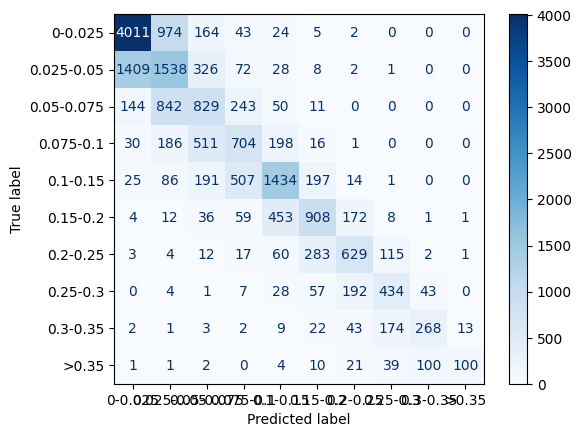

Classification Report:

              precision    recall  f1-score   support

     0-0.025       0.71      0.64      0.67      6288
  0.025-0.05       0.42      0.45      0.44      3396
  0.05-0.075       0.40      0.39      0.40      2122
   0.075-0.1       0.43      0.43      0.43      1646
    0.1-0.15       0.63      0.58      0.60      2456
    0.15-0.2       0.60      0.55      0.57      1654
    0.2-0.25       0.58      0.56      0.57      1126
    0.25-0.3       0.56      0.57      0.56       766
    0.3-0.35       0.65      0.50      0.56       537
       >0.35       0.87      0.36      0.51       278

   micro avg       0.57      0.54      0.55     20269
   macro avg       0.58      0.50      0.53     20269
weighted avg       0.58      0.54      0.55     20269

Male error:  0.002637229924278707
Female error:  0.0019556134021384624


0.0029780381853488293

In [43]:
def is_grayscale(image_path):
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)
    if np.array_equal(img_np[..., 0], img_np[..., 1]) and np.array_equal(img_np[..., 0], img_np[..., 2]):
        return True
    return False

df_val['is_grayscale'] = df_val['filename'].apply(lambda x: is_grayscale(f"{image_dir}/{x}"))
# 打印数据帧的前几行，检查是否有 'is_grayscale' 列
print(df_val.head())

class Dataset_val(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']
        is_gray = row['is_grayscale']
        

        # Load data and get label
        img = Image.open(f"{self.image_dir}/{filename}")  
        X = self.transform(img)

        y = row['FaceOcclusion']     
        y = np.float32(y)

        gender = row['gender'] # changed to have round values 0 or 1

        return X, y, gender, filename, is_gray

val_set = Dataset_val(df_val, image_dir)
params_val = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

val_loader = torch.utils.data.DataLoader(val_set, **params_val)

results_list = []
for batch_idx, (X, y, gender, filename, is_gray) in tqdm(enumerate(val_loader), total=len(val_loader)):
    X, y = X.to(device), y.to(device).view(-1, 1)
    y_preds = []
    for i in range(len(X)):  
        if is_gray[i].item(): 
            y_pred = model_grayscale(X[i].unsqueeze(0))  
        else:
            y_pred = model_color(X[i].unsqueeze(0)) 
        y_preds.append(y_pred.item())
    
    y_np = y.cpu().numpy().flatten()
    
    true_ranges = pd.cut(y_np, bins=bins, labels=labels, include_lowest=True)
    pred_ranges = pd.cut(y_preds, bins=bins, labels=labels, include_lowest=True)
    
    for i in range(len(X)):
        results_list.append({
            'true_range': str(true_ranges[i]), 
            'pred_range': str(pred_ranges[i]),
            'pred': float(y_preds[i]),
            'target': float(y_np[i]),
            'gender': float(gender[i])
        })

results_df = pd.DataFrame(results_list)

y_true = results_df['true_range']
y_pred = results_df['pred_range']
cm = confusion_matrix(y_true, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print(f"Classification Report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels))



results_male = results_df.loc[results_df["gender"] > 0.5]
results_female = results_df.loc[results_df["gender"] < 0.5]

metric_fn(results_male,results_female)

In [44]:
results_df.head()

,true_range,pred_range,pred,target,gender
0,0.05-0.075,0.075-0.1,0.092582,0.061,1.000
1,0.2-0.25,0-0.025,0.024936,0.213,0.845
2,0.15-0.2,0.025-0.05,0.038794,0.195,0.999
3,0-0.025,0-0.025,0.004256,0.015,0.999
4,0.1-0.15,0.1-0.15,0.101608,0.108,0.001


### Face mesh(doesn't work really well)

In [48]:
import cv2
import mediapipe as mp
import time
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from PIL import Image
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

def get_face_landmarks(image):
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            landmarks = [(lm.x, lm.y, lm.z) for lm in face_landmarks.landmark]
            return landmarks
    return None



In [50]:
class FaceOcclusionDataset(Dataset):
    def __init__(self, df, image_dir):
        self.image_dir = image_dir
        self.df = df
        self.transform = transforms.ToTensor()
         
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.loc[index]
        filename = row['filename']
        img_path = f"{self.image_dir}/{filename}"
        img = cv2.imread(img_path)
        landmarks = get_face_landmarks(img)
        y = row['FaceOcclusion']
        gender = row['gender']
        if landmarks:
            X = torch.tensor(landmarks).view(-1)
        else:
            X = torch.zeros(468*3)  
        y = torch.tensor([y], dtype=torch.float32)
        return X, y, gender, filename


training_set = FaceOcclusionDataset(df_train, image_dir)
validation_set = FaceOcclusionDataset(df_val, image_dir)

params_train = {'batch_size': 8, 'shuffle': True, 'num_workers': 0}
params_val = {'batch_size': 8, 'shuffle': False, 'num_workers': 0}

training_generator = DataLoader(training_set, **params_train)
validation_generator = DataLoader(validation_set, **params_val)


In [55]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(468*3, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# 将模型移动到GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


  0%|          | 0/8134 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [54]:
num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


Epoch 1/3


  0%|          | 0/8134 [00:00<?, ?it/s]


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [8, 1404]

## Evaluate metric on validation split

In [ ]:
def error_fn(df):
    pred = df.loc[:, "pred"]
    ground_truth = df.loc[:, "target"]
    weight = 1/30 + ground_truth

    return np.sum(((pred - ground_truth)**2) * weight, axis=0) / np.sum(weight, axis=0)

def metric_fn(female, male):
    err_male = error_fn(male)
    err_female = error_fn(female)
    print("Male error: ", err_male)
    print("Female error: ", err_female)
    
    return (err_male + err_female) / 2 + abs(err_male - err_female)

In [ ]:
results_df.head()

,pred,target,gender
0,0.027467,0.000,0.987
1,0.014575,0.015,0.997
2,0.012943,0.017,0.998
3,0.027558,0.020,0.997
4,0.050533,0.000,0.999


<Axes: >

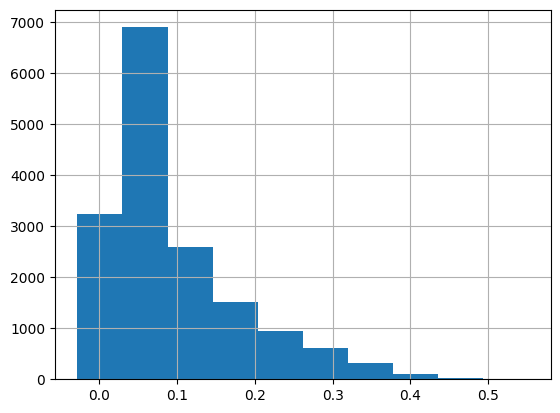

In [ ]:
results_df['pred'].hist()

100%|██████████| 2034/2034 [00:59<00:00, 34.13it/s]


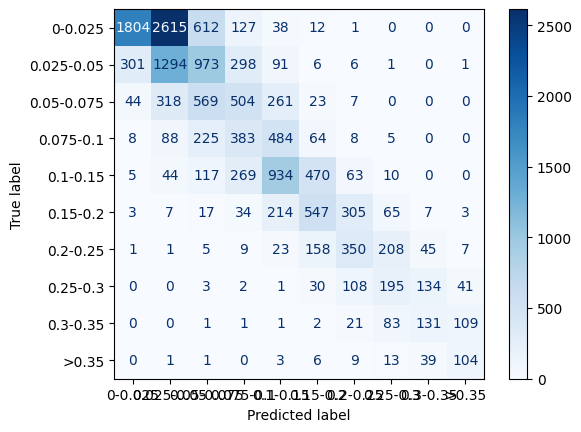

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
    X, y = X.to(device), y.to(device).view(-1, 1)
    y_pred = model(X)
    for i in range(len(X)):
        true_range = pd.cut([float(y[i])], bins=bins, labels=labels, include_lowest=True)[0]
        pred_range = pd.cut([float(y_pred[i])], bins=bins, labels=labels, include_lowest=True)[0]
        results_list.append({'true_range': str(true_range), 'pred_range': str(pred_range),'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])})


results_df = pd.DataFrame(results_list)

y_true = results_df['true_range']
y_pred = results_df['pred_range']
cm = confusion_matrix(y_true, y_pred, labels=labels)

print(f"Classification Report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels))


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()




In [ ]:
print(f"Classification Report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels))

Classification Report:

              precision    recall  f1-score   support

     0-0.025       0.83      0.34      0.48      5339
  0.025-0.05       0.30      0.43      0.35      2978
  0.05-0.075       0.23      0.33      0.27      1727
   0.075-0.1       0.24      0.30      0.26      1265
    0.1-0.15       0.46      0.49      0.47      1912
    0.15-0.2       0.42      0.46      0.43      1202
    0.2-0.25       0.40      0.43      0.42       807
    0.25-0.3       0.34      0.38      0.36       514
    0.3-0.35       0.37      0.38      0.37       349
       >0.35       0.39      0.59      0.47       176

   micro avg       0.39      0.39      0.39     16269
   macro avg       0.40      0.41      0.39     16269
weighted avg       0.50      0.39      0.40     16269



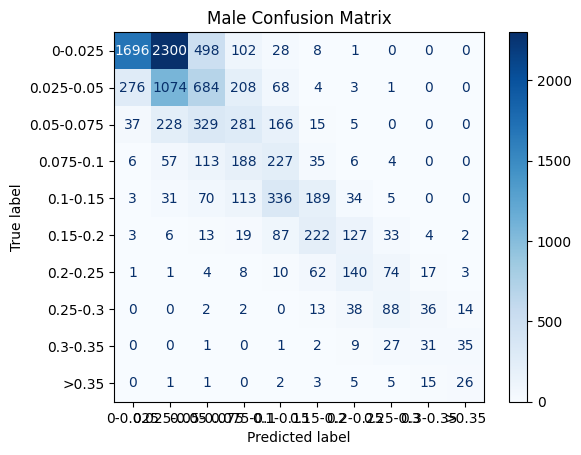

Classification Report for Male Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.84      0.36      0.50      4759
  0.025-0.05       0.29      0.46      0.36      2325
  0.05-0.075       0.19      0.31      0.24      1062
   0.075-0.1       0.20      0.30      0.24       636
    0.1-0.15       0.36      0.43      0.39       781
    0.15-0.2       0.40      0.43      0.42       516
    0.2-0.25       0.38      0.44      0.41       320
    0.25-0.3       0.37      0.46      0.41       193
    0.3-0.35       0.30      0.29      0.30       106
       >0.35       0.33      0.45      0.38        58

   micro avg       0.39      0.38      0.39     10756
   macro avg       0.37      0.39      0.36     10756
weighted avg       0.53      0.38      0.41     10756



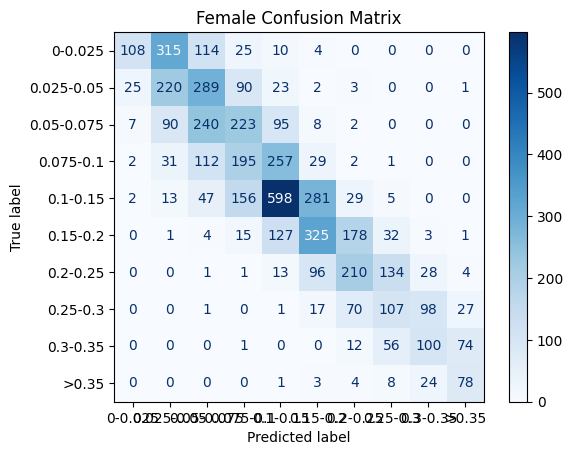

Classification Report for Female Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.75      0.19      0.30       580
  0.025-0.05       0.33      0.34      0.33       653
  0.05-0.075       0.30      0.36      0.33       665
   0.075-0.1       0.28      0.31      0.29       629
    0.1-0.15       0.53      0.53      0.53      1131
    0.15-0.2       0.42      0.47      0.45       686
    0.2-0.25       0.41      0.43      0.42       487
    0.25-0.3       0.31      0.33      0.32       321
    0.3-0.35       0.40      0.41      0.40       243
       >0.35       0.42      0.66      0.51       118

   micro avg       0.40      0.40      0.40      5513
   macro avg       0.41      0.40      0.39      5513
weighted avg       0.43      0.40      0.39      5513



In [ ]:
results_male = results_df.loc[results_df["gender"] > 0.5]
results_female = results_df.loc[results_df["gender"] < 0.5]
# print(results_male)
# print(results_female)

def plot_confusion_matrix(results, title):
    y_true = results['true_range']
    y_pred = results['pred_range']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()
    
    print(f"Classification Report for {title}:\n")
    print(classification_report(y_true, y_pred, labels=labels, target_names=labels))


# Male confusion matrix
plot_confusion_matrix(results_male, "Male Confusion Matrix")

# Female confusion matrix
plot_confusion_matrix(results_female, "Female Confusion Matrix")

In [ ]:
metric_fn(results_male, results_female)

0.002332612480355155
0.0028553619690595594


0.0031167367134117617

## Evaluating your Test DataSet

In [ ]:
# original
class Dataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")

        X = self.transform(img)

        return X, filename
    
    
test_set = Dataset_test(df_test, image_dir)

params_test = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

test_generator = torch.utils.data.DataLoader(test_set, **params_test)

results_list = []
for batch_idx, (X, filename) in tqdm(enumerate(test_generator), total=len(test_generator)):
        X = X.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i])
                                 })
test_df = pd.DataFrame(results_list)

In [ ]:
### face mesh

'''
class faceDataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        img_path = f"{self.image_dir}/{filename}"
        img = cv2.imread(img_path)
        landmarks = get_face_landmarks(img)
        
        if landmarks:
            X = torch.tensor(landmarks).view(-1)
        else:
            X = torch.zeros(468*3)  # 468个特征点，每个特征点有x, y, z三个坐标
        

        return X, filename

'''

'\nclass faceDataset_test(torch.utils.data.Dataset):\n    \'Characterizes a dataset for PyTorch\'\n    def __init__(self, df, image_dir):\n         \'Initialization\'\n         self.image_dir = image_dir\n         self.df = df\n         self.transform = transforms.ToTensor()\n         \n    def __len__(self):\n        \'Denotes the total number of samples\'\n        return len(self.df)\n\n    def __getitem__(self, index):\n        \'Generates one sample of data\'\n        # Select sample\n        row = self.df.loc[index]\n        filename = row[\'filename\']\n\n        img_path = f"{self.image_dir}/{filename}"\n        img = cv2.imread(img_path)\n        landmarks = get_face_landmarks(img)\n        \n        if landmarks:\n            X = torch.tensor(landmarks).view(-1)\n        else:\n            X = torch.zeros(468*3)  # 468个特征点，每个特征点有x, y, z三个坐标\n        \n\n        return X, filename\n\n'

In [ ]:
def is_grayscale(image_path):
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)
    if np.array_equal(img_np[..., 0], img_np[..., 1]) and np.array_equal(img_np[..., 0], img_np[..., 2]):
        return True
    return False


df_test['is_grayscale'] = df_test['filename'].apply(lambda x: is_grayscale(f"{image_dir}/{x}"))
df_test.head()


,filename,is_grayscale
0,database2/database2/test/0.jpg,False
1,database2/database2/test/1.jpg,False
2,database2/database2/test/2.jpg,True
3,database2/database2/test/3.jpg,False
4,database2/database2/test/4.jpg,False


In [ ]:
# 2 models test set
class Dataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']
        is_gray = row['is_grayscale']
        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")

        X = self.transform(img)

        return X, is_gray, filename

test_set = Dataset_test(df_test, image_dir)
params_test = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

test_loader = torch.utils.data.DataLoader(test_set, **params_test)



results_list = []
for batch_idx, (X, is_gray, filename) in tqdm(enumerate(test_loader), total=len(test_loader)):
    X = X.to(device)
    for i in range(len(X)):  
        if is_gray[i].item():  
            y_pred = model_grayscale(X[i].unsqueeze(0)) 
        else:
            y_pred = model_color(X[i].unsqueeze(0)) 
        

        results_list.append({'pred': float(y_pred.squeeze().item())})


test_df = pd.DataFrame(results_list)

100%|██████████| 3814/3814 [02:41<00:00, 23.57it/s]


In [ ]:
test_df.head()

,pred
0,0.280279
1,0.344143
2,0.361664
3,0.297884
4,0.383106


### Preparing your file for Submission

In [ ]:
test_df.to_csv("Data_Challenge.csv", header = None, index = None)